# Illustrative Example: DTA-GNN workflow for P00533 (Google Colab)

This notebook runs on **Google Colab** without a local ChEMBL database. It uses the ChEMBL **web API** to fetch data (slower than sqlite but works everywhere).

**Setup:** Run the cell below to install `dta_gnn`, then run all cells in order. For faster training, enable a GPU: *Runtime → Change runtime type → GPU*. If you use the W&B HPO section (Section 2), run `wandb login` when prompted (get your API key from [wandb.ai](https://wandb.ai)).

Workflow: (1) Dataset construction + leakage, (2) HPO for GraphSAGE, (3) Training + evaluation + top 5 molecules, (4) Inference on 3 SMILES, (5) Embedding PCA plots.

In [ ]:
# Install DTA-GNN (includes PyTorch, PyG, wandb). Restart runtime after this if imports fail.
!pip install --index-url https://test.pypi.org/simple/ \
  --extra-index-url https://pypi.org/simple \
  dta-gnn -q
print("dta_gnn installed. If imports fail below, use Runtime → Restart session, then run from the Setup cell.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.0 

## 0. Setup

Imports, fixed random seed, device selection, and run directories.

In [ ]:
import random
import json
import shutil
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dta_gnn.pipeline import Pipeline
from dta_gnn.io.target_mapping import map_uniprot_to_chembl_targets_web, parse_uniprot_accessions
from dta_gnn.models.gnn import GnnTrainConfig, train_gnn_on_run, extract_gnn_embeddings_on_run, _get_device
from dta_gnn.models.hyperopt import HyperoptConfig, optimize_gnn_wandb
from dta_gnn.models.predict import predict_with_gnn
from dta_gnn.audits.leakage import audit_scaffold_leakage
from scipy.stats import pearsonr
from sklearn.decomposition import PCA

# Fixed seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)

# Device (CPU / GPU)
device = _get_device(None)
print(f"Seed: {seed}")
print(f"Device: {device}")

# Run directories: separate folders for random and scaffold splits
RUN_DIR_RANDOM = Path("runs/p00533_random")
RUN_DIR_SCAFFOLD = Path("runs/p00533_scaffold")
RUN_DIR_RANDOM.mkdir(parents=True, exist_ok=True)
RUN_DIR_SCAFFOLD.mkdir(parents=True, exist_ok=True)
# Paper-ready artifacts (tables, figures, best hyperparameters) for LaTeX
PAPER_ARTIFACTS = RUN_DIR_SCAFFOLD / "paper_artifacts"
PAPER_ARTIFACTS.mkdir(parents=True, exist_ok=True)
print(f"Run dir (random):  {RUN_DIR_RANDOM}")
print(f"Run dir (scaffold): {RUN_DIR_SCAFFOLD}")
print(f"Paper artifacts:   {PAPER_ARTIFACTS}")

Seed: 42
Device: cuda
Run dir (random):  runs/p00533_random
Run dir (scaffold): runs/p00533_scaffold
Paper artifacts:   runs/p00533_scaffold/paper_artifacts


### Optional: Use datasets from Google Drive

Instead of fetching from the ChEMBL web API, you can use your own datasets stored on Google Drive. Upload folders that contain `dataset.csv`, `compounds.csv`, and `metadata.json` (e.g. from a previous run or from the [DTA-GNN repo](https://github.com/your-org/DTA-GNN)), then:

1. Set **`USE_DRIVE_DATASETS = True`** below.
2. Set **`DRIVE_PATH_SCAFFOLD`** and **`DRIVE_PATH_RANDOM`** to the full paths of those folders on your Drive (e.g. `/content/drive/MyDrive/runs/p00533_scaffold`).
3. Run this cell to mount Drive and copy the files into the notebook run directories.

If you keep **`USE_DRIVE_DATASETS = False`**, the next section will fetch data from ChEMBL as usual. Run this cell in any case so that `USE_DRIVE_DATASETS` is defined.

In [ ]:
# Set to True to use your own datasets from Google Drive instead of ChEMBL
USE_DRIVE_DATASETS = True
# Paths to folders on Google Drive containing dataset.csv, compounds.csv, metadata.json
DRIVE_PATH_SCAFFOLD = "/content/drive/MyDrive/runs/P00533_scaffold"
DRIVE_PATH_RANDOM = "/content/drive/MyDrive/runs/P00533_random"
if USE_DRIVE_DATASETS:
    from google.colab import drive
    drive.mount("/content/drive")
    for src_dir, run_dir in [
        (Path(DRIVE_PATH_RANDOM), RUN_DIR_RANDOM),
        (Path(DRIVE_PATH_SCAFFOLD), RUN_DIR_SCAFFOLD),
    ]:
        for name in ("dataset.csv", "compounds.csv", "metadata.json"):
            src = src_dir / name
            if not src.exists():
                raise FileNotFoundError(f"Expected {src} (folder on Drive: {src_dir})")
            shutil.copy2(src, run_dir / name)
        print(f"Copied {src_dir} -> {run_dir}")
else:
    print("Using ChEMBL web API for datasets (USE_DRIVE_DATASETS is False).")

Mounted at /content/drive
Copied /content/drive/MyDrive/runs/P00533_random -> runs/p00533_random
Copied /content/drive/MyDrive/runs/P00533_scaffold -> runs/p00533_scaffold


# Illustrative Example: DTA-GNN workflow for P00533 (EGFR)

This notebook demonstrates an end-to-end Drug–Target Affinity (DTA) workflow using the DTA-GNN toolkit for target **P00533** (UniProt ID, EGFR):

1. **Dataset construction** (random + scaffold splits) and leakage visualization
2. **Hyperparameter optimization** for GraphSAGE (lr, num_layers)
3. **Training** with best hyperparameters, evaluation, and top 5 molecules
4. **Inference** on 3 SMILES
5. **Embedding extraction** and PCA scatter plots

All code runs top-to-bottom with a fixed random seed (42). Outputs are saved inline.

## 1. Dataset construction (P00533)

If **USE_DRIVE_DATASETS** is False, this step builds two datasets for target P00533 from the ChEMBL web API (random + scaffold split) and saves `dataset.csv`, `compounds.csv`, and `metadata.json` in each run directory. If you set **USE_DRIVE_DATASETS = True** and ran the optional Google Drive cell, this step only loads those files from the run directories.

In [ ]:
if not USE_DRIVE_DATASETS:
    # Map UniProt P00533 to ChEMBL target IDs
    UNIPROT_ID = "P00533"
    accessions = parse_uniprot_accessions(UNIPROT_ID)
    mapping_result = map_uniprot_to_chembl_targets_web(accessions)
    target_ids = mapping_result.resolved_target_chembl_ids
    if not target_ids:
        raise ValueError(
            f"Could not map UniProt {UNIPROT_ID} to any ChEMBL targets. "
            "Check network access or UniProt ID."
        )
    print(f"Mapped {UNIPROT_ID} to ChEMBL targets: {target_ids}")

    # Pipeline (web API; use sqlite_path for local DB if available)
    pipeline = Pipeline(source_type="web")

    # Dataset A: random split
    df_random = pipeline.build_dta(
        target_ids=target_ids,
        standard_types=["IC50", "Ki", "Kd"],
        split_method="random",
        test_size=0.2,
        val_size=0.1,
        featurize=False,
    )
    if df_random.empty:
        raise ValueError("Dataset is empty after building with random split.")

    df_random.to_csv(RUN_DIR_RANDOM / "dataset.csv", index=False)
    compounds_random = df_random[["molecule_chembl_id", "smiles"]].drop_duplicates()
    compounds_random.to_csv(RUN_DIR_RANDOM / "compounds.csv", index=False)
    (RUN_DIR_RANDOM / "metadata.json").write_text(
        json.dumps({
            "uniprot_id": UNIPROT_ID,
            "target_chembl_ids": target_ids,
            "split_method": "random",
            "n_samples": len(df_random),
            "n_compounds": len(compounds_random),
        }, indent=2)
    )
    print(f"\nRandom split: {len(df_random)} samples")
    print(df_random["split"].value_counts())

    # Dataset B: scaffold split
    pipeline_scaffold = Pipeline(source_type="web")
    df_scaffold = pipeline_scaffold.build_dta(
        target_ids=target_ids,
        standard_types=["IC50", "Ki", "Kd"],
        split_method="scaffold",
        test_size=0.2,
        val_size=0.1,
        featurize=False,
    )
    if df_scaffold.empty:
        raise ValueError("Dataset is empty after building with scaffold split.")

    df_scaffold.to_csv(RUN_DIR_SCAFFOLD / "dataset.csv", index=False)
    compounds_scaffold = df_scaffold[["molecule_chembl_id", "smiles"]].drop_duplicates()
    compounds_scaffold.to_csv(RUN_DIR_SCAFFOLD / "compounds.csv", index=False)
    (RUN_DIR_SCAFFOLD / "metadata.json").write_text(
        json.dumps({
            "uniprot_id": UNIPROT_ID,
            "target_chembl_ids": target_ids,
            "split_method": "scaffold",
            "n_samples": len(df_scaffold),
            "n_compounds": len(compounds_scaffold),
        }, indent=2)
    )
    print(f"\nScaffold split: {len(df_scaffold)} samples")
    print(df_scaffold["split"].value_counts())
else:
    # Load datasets from run dirs (already copied from Google Drive in the previous cell)
    df_random = pd.read_csv(RUN_DIR_RANDOM / "dataset.csv")
    df_scaffold = pd.read_csv(RUN_DIR_SCAFFOLD / "dataset.csv")
    print("Loaded datasets from Google Drive.")
    print(f"\nRandom split: {len(df_random)} samples")
    print(df_random["split"].value_counts())
    print(f"\nScaffold split: {len(df_scaffold)} samples")
    print(df_scaffold["split"].value_counts())

Loaded datasets from Google Drive.

Random split: 14530 samples
split
train    10171
test      2906
val       1453
Name: count, dtype: int64

Scaffold split: 14530 samples
split
train    10174
test      2885
val       1451
Name: count, dtype: int64


### 1.2 Leakage ratio visualization

Leakage ratio = (number of test scaffolds also present in train) / (number of test scaffolds). Lower is better; scaffold split should have lower leakage than random.

Leakage ratio (Random):   0.5105740181268882
Leakage ratio (Scaffold): 0.0


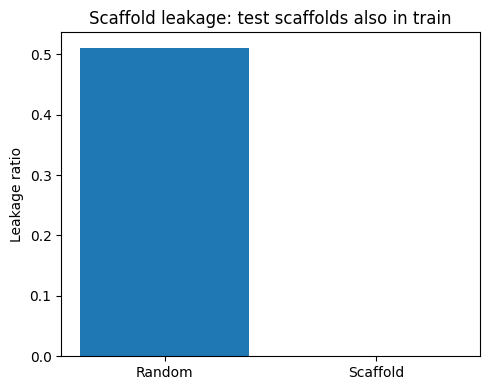

In [ ]:
# Leakage audit for both splits
train_r = df_random[df_random["split"] == "train"]
test_r = df_random[df_random["split"] == "test"]
leak_random = audit_scaffold_leakage(train_r, test_r, smiles_col="smiles")

train_s = df_scaffold[df_scaffold["split"] == "train"]
test_s = df_scaffold[df_scaffold["split"] == "test"]
leak_scaffold = audit_scaffold_leakage(train_s, test_s, smiles_col="smiles")

print("Leakage ratio (Random):  ", leak_random["leakage_ratio"])
print("Leakage ratio (Scaffold):", leak_scaffold["leakage_ratio"])

# Table for paper
leak_df = pd.DataFrame({
    "Split": ["Random", "Scaffold"],
    "Leakage ratio": [leak_random["leakage_ratio"], leak_scaffold["leakage_ratio"]],
})
leak_df.to_csv(PAPER_ARTIFACTS / "table_leakage_ratio.csv", index=False)
with open(PAPER_ARTIFACTS / "table_leakage_ratio.tex", "w") as f:
    f.write(leak_df.to_latex(index=False, float_format="%.4f", na_rep="--"))

# Bar plot (PNG + PDF for LaTeX)
fig, ax = plt.subplots(figsize=(5, 4))
ax.bar(["Random", "Scaffold"], [leak_random["leakage_ratio"], leak_scaffold["leakage_ratio"]], color=["#1f77b4", "#ff7f0e"])
ax.set_ylabel("Leakage ratio")
ax.set_title("Scaffold leakage: test scaffolds also in train")
plt.tight_layout()
plt.savefig(RUN_DIR_SCAFFOLD / "leakage_ratio.png", dpi=120)
plt.savefig(PAPER_ARTIFACTS / "fig_leakage_ratio.pdf", bbox_inches="tight")
plt.show()

## 2. Hyperparameter optimization (GraphSAGE)

W&B Bayes sweep over **lr** (log-uniform in [1e-5, 1e-2]) and **num_layers** (2–6). Fixed: dropout=0.25, head_mlp_layers=2, hidden_dim=256, batch_size=32, epochs=30. Metric: validation score (R² or -RMSE, maximize). Requires `wandb` login and `pip install 'dta_gnn[wandb]'`.

In [ ]:
# Disable W&B notebook hooks to avoid ZMQ/socket conflicts (Colab or Jupyter)
import os
old_notebook_name = os.environ.get("WANDB_NOTEBOOK_NAME")
os.environ["WANDB_NOTEBOOK_NAME"] = ""

# W&B Bayes sweep: lr (log-uniform [1e-5, 1e-2]), num_layers (2-6)
# Fixed: dropout=0.25, head_mlp_layers=2, hidden_dim=256, batch_size=128, epochs=100
hpo_config = HyperoptConfig(
    model_type="GNN",
    architecture="sage",
    optimize_lr=True,
    lr_min=1e-5,
    lr_max=1e-2,
    optimize_num_layers=True,
    num_layers_min=2,
    num_layers_max=6,
    n_trials=50,
    sampler_seed=seed,
    epochs_default=100,
    batch_size_default=64,
    hidden_dim_default=256,
    dropout_default=0.25,
    head_mlp_layers_default=2,
    embedding_dim_default=128,
    device="auto",
)
try:
    result_hpo = optimize_gnn_wandb(
        RUN_DIR_SCAFFOLD,
        config=hpo_config,
        project="dta_gnn_p00533",
        entity=None,
        sweep_name="p00533_graphsage_hpo",
    )
finally:
    if old_notebook_name is not None:
        os.environ["WANDB_NOTEBOOK_NAME"] = old_notebook_name
    elif "WANDB_NOTEBOOK_NAME" in os.environ:
        del os.environ["WANDB_NOTEBOOK_NAME"]


# Extract best hyperparameters for downstream training
best_lr = float(result_hpo.best_params["lr"])
best_num_layers = int(result_hpo.best_params["num_layers"])
# best_value is val_score (R² or -RMSE, maximized); full trial history is in W&B
df_trials = pd.DataFrame([{
    "trial": result_hpo.best_trial_number,
    "lr": best_lr,
    "num_layers": best_num_layers,
    "val_score": result_hpo.best_value,
}])
print(f"\nBest: lr={best_lr:.2e}, num_layers={best_num_layers} (val_score={result_hpo.best_value:.4f})")
print("Full trial history: see W&B project dta_gnn_p00533")
display(df_trials)

# Paper artifacts: best hyperparameters (val_score = R² or -RMSE)
best_params = {"lr": best_lr, "num_layers": best_num_layers, "val_score": float(result_hpo.best_value)}
(PAPER_ARTIFACTS / "best_hyperparameters.json").write_text(json.dumps(best_params, indent=2))
best_tex = (
    "%% Best hyperparameters (GraphSAGE HPO, W&B Bayes sweep)\n"
    "\\begin{tabular}{ll}\n"
    "  \\hline\n"
    f"  Learning rate & {best_lr:.2e} \\\\\n"
    f"  Num. GNN layers & {best_num_layers} \\\\\n"
    f"  Val. score (R$^2$ or $-$RMSE) & {result_hpo.best_value:.4f} \\\\\n"
    "  \\hline\n"
    "\\end{tabular}\n"
)
(PAPER_ARTIFACTS / "best_hyperparameters.tex").write_text(best_tex)
# Save best params path for reference (W&B sweep saves full best_params JSON)
df_trials.to_csv(PAPER_ARTIFACTS / "table_hpo_best.csv", index=False)
with open(PAPER_ARTIFACTS / "table_hpo_best.tex", "w") as f:
    f.write(df_trials.to_latex(index=False, float_format="%.4f", na_rep="--"))

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 1854hqcy
Sweep URL: https://wandb.ai/lab_bio_inf/dta_gnn_p00533/sweeps/1854hqcy

Starting W&B sweep with 50 trials
Sweep ID: 1854hqcy
Architecture: sage



wandb: Agent Starting Run: 0suragef with config:
wandb: 	lr: 0.007006072821627173
wandb: 	num_layers: 3
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.
wandb: Currently logged in as: gozsari (lab_bio_inf) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



[Trial 0] Starting GNN training...
[Trial 0] Run ID: 0suragef
[Trial 0] Training GNN with config: epochs=100, batch_size=64, lr=0.007006, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.007006)...
  ✓ New best model at epoch 1 (val_R²=-0.6025)
  Epoch 1/100 completed (train_loss: 42.6879, val_loss: 3.5355)
  ✓ New best model at epoch 2 (val_R²=-0.2849)
  ✓ New best model at epoch 3 (val_R²=-0.0075)
  ✓ New best model at epoch 4 (val_R²=0.0269)
  ✓ New best model at epoch 5 (val_R²=0.0748)
  ✓ New best model at epoch 6 (val_R²=0.1852)
  ✓ New best model at epoch 9 (val_R²=0.2162)
  ✓ New best model at epoch 10 (val_R²=0.3544)
  ✓ New best model at epoch 15 (val_R²=0.4008)
  ✓ New best model at epoch 16 (val_R²=0.4360)
  ✓ New best model at epoch 17 (val_R²=0.4704)
  Epoch 20/100 completed (train_loss: 1.4722, val_loss: 1.3175)
  ✓ New best model at epoch 27 (val_R²=0.5008)
  ✓ New best model at epoch 32 (val_R²=0.5097)
  ✓ New best model at epoch 38 (val_R²=0.5563)
 

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▅▄▄▄▂▃▃▂▂▂▂▃▁▁▁▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁
val/mae,█▅▅▄▃▃▂▃▄▃▂▃▂▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁
+3,...


[Trial 0] New best score: 0.6332 (trial #0)


wandb: Agent Starting Run: ex3wnor9 with config:
wandb: 	lr: 2.0946525115647274e-05
wandb: 	num_layers: 4
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 1] Starting GNN training...
[Trial 1] Run ID: ex3wnor9
[Trial 1] Training GNN with config: epochs=100, batch_size=64, lr=0.000021, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000021)...
  ✓ New best model at epoch 1 (val_R²=-1.5775)
  Epoch 1/100 completed (train_loss: 15.6791, val_loss: 5.7291)
  ✓ New best model at epoch 2 (val_R²=-1.1286)
  ✓ New best model at epoch 3 (val_R²=-0.8017)
  ✓ New best model at epoch 4 (val_R²=-0.6633)
  ✓ New best model at epoch 5 (val_R²=-0.5029)
  ✓ New best model at epoch 6 (val_R²=-0.3755)
  ✓ New best model at epoch 7 (val_R²=-0.3525)
  ✓ New best model at epoch 8 (val_R²=-0.2988)
  ✓ New best model at epoch 11 (val_R²=-0.2296)
  ✓ New best model at epoch 13 (val_R²=-0.2217)
  ✓ New best model at epoch 14 (val_R²=-0.0301)
  Epoch 20/100 completed (train_loss: 2.6897, val_loss: 2.4809)
  ✓ New best model at epoch 28 (val_R²=0.0699)
  ✓ New best model at epoch 33 (val_R²=0.0892)
  ✓ New best model at epoch 34 (val_R²=0.

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▆▅▄▄▂▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mae,█▇▄▅▄▄▃▃▃▄▃▃▃▃▃▃▃▃▂▃▂▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
+3,...


[Trial 1] Score: 0.3874 (best so far: 0.6332)


wandb: Agent Starting Run: f4z409zs with config:
wandb: 	lr: 2.6396036530591895e-05
wandb: 	num_layers: 3
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 2] Starting GNN training...
[Trial 2] Run ID: f4z409zs
[Trial 2] Training GNN with config: epochs=100, batch_size=64, lr=0.000026, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000026)...
  ✓ New best model at epoch 1 (val_R²=-0.8187)
  Epoch 1/100 completed (train_loss: 4.5484, val_loss: 4.0479)
  ✓ New best model at epoch 2 (val_R²=-0.6997)
  ✓ New best model at epoch 3 (val_R²=-0.4576)
  ✓ New best model at epoch 4 (val_R²=-0.2577)
  ✓ New best model at epoch 5 (val_R²=-0.2185)
  ✓ New best model at epoch 12 (val_R²=-0.1880)
  ✓ New best model at epoch 14 (val_R²=-0.0884)
  Epoch 20/100 completed (train_loss: 2.4445, val_loss: 2.5794)
  ✓ New best model at epoch 23 (val_R²=-0.0793)
  ✓ New best model at epoch 25 (val_R²=0.0384)
  ✓ New best model at epoch 33 (val_R²=0.0724)
  Epoch 40/100 completed (train_loss: 2.1590, val_loss: 2.2755)
  ✓ New best model at epoch 41 (val_R²=0.1129)
  ✓ New best model at epoch 43 (val_R²=0.1192)
  ✓ New best model at epo

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▆▄▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▆▅▄▄▆▄▄▄▄▅▄▃▃▃▃▃▂▃▂▂▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val/mae,▇▇█▅█▅▆▆▄▅▄▃▄▅▅▆▃▃▂▃▃▃▂▂▂▂▁▂▂▂▁▁▁▂▁▁▂▁▁▁
+3,...


[Trial 2] Score: 0.4252 (best so far: 0.6332)


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gp1yrn60 with config:
wandb: 	lr: 0.009356651985901215
wandb: 	num_layers: 2
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 3] Starting GNN training...
[Trial 3] Run ID: gp1yrn60
[Trial 3] Training GNN with config: epochs=100, batch_size=64, lr=0.009357, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.009357)...
  ✓ New best model at epoch 1 (val_R²=-0.4525)
  Epoch 1/100 completed (train_loss: 53.5560, val_loss: 3.2123)
  ✓ New best model at epoch 2 (val_R²=-0.1289)
  ✓ New best model at epoch 6 (val_R²=0.1002)
  ✓ New best model at epoch 7 (val_R²=0.1654)
  ✓ New best model at epoch 8 (val_R²=0.1980)
  ✓ New best model at epoch 9 (val_R²=0.2782)
  ✓ New best model at epoch 10 (val_R²=0.3073)
  ✓ New best model at epoch 13 (val_R²=0.3445)
  ✓ New best model at epoch 15 (val_R²=0.3456)
  ✓ New best model at epoch 16 (val_R²=0.4212)
  ✓ New best model at epoch 19 (val_R²=0.4416)
  Epoch 20/100 completed (train_loss: 1.5465, val_loss: 1.6498)
  ✓ New best model at epoch 24 (val_R²=0.4571)
  ✓ New best model at epoch 27 (val_R²=0.4627)
  ✓ New best model at epoch 30 (val_R²=0.4720)
 

epoch,▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,██▆▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,▄▄█▃▃▂▂▃▂▂▃▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val/mae,██▅▅▄▃▅▅▂▅▂▃▂▂▃▃▂▂▄▃▂▂▂▂▂▂▁▂▂▁▃▂▂▁▂▂▁▁▂▂
+3,...


[Trial 3] Score: 0.5760 (best so far: 0.6332)


wandb: Agent Starting Run: cx2ddynv with config:
wandb: 	lr: 0.0094025880764317
wandb: 	num_layers: 5
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 4] Starting GNN training...
[Trial 4] Run ID: cx2ddynv
[Trial 4] Training GNN with config: epochs=100, batch_size=64, lr=0.009403, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.009403)...
  ✓ New best model at epoch 1 (val_R²=-1.0366)
  Epoch 1/100 completed (train_loss: 43.9148, val_loss: 4.5071)
  ✓ New best model at epoch 2 (val_R²=-0.3917)
  ✓ New best model at epoch 4 (val_R²=-0.0891)
  ✓ New best model at epoch 5 (val_R²=-0.0200)
  ✓ New best model at epoch 7 (val_R²=0.1766)
  ✓ New best model at epoch 9 (val_R²=0.2624)
  ✓ New best model at epoch 11 (val_R²=0.3381)
  ✓ New best model at epoch 13 (val_R²=0.3433)
  ✓ New best model at epoch 16 (val_R²=0.3937)
  Epoch 20/100 completed (train_loss: 1.5076, val_loss: 1.5545)
  ✓ New best model at epoch 24 (val_R²=0.4107)
  ✓ New best model at epoch 25 (val_R²=0.4568)
  ✓ New best model at epoch 28 (val_R²=0.4793)
  ✓ New best model at epoch 32 (val_R²=0.4829)
  ✓ New best model at epoch 34 (val_R²=0.4851)

epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,▆▆█▅▃▃▃▃▄▂▂▄▂▂▂▂▄▂▂▂▂▂▁▂▂▁▁▂▁▂▂▁▂▁▁▂▁▂▁▂
val/mae,█▆▅█▅▅▄▅▄▄▆▃▃▂▂▃▂▃▂▂▂▃▂▃▃▃▂▂▂▂▂▁▂▂▁▂▁▃▂▁
+3,...


[Trial 4] Score: 0.6186 (best so far: 0.6332)


wandb: Agent Starting Run: 6xevjdq2 with config:
wandb: 	lr: 0.008917549893116012
wandb: 	num_layers: 4
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 5] Starting GNN training...
[Trial 5] Run ID: 6xevjdq2
[Trial 5] Training GNN with config: epochs=100, batch_size=64, lr=0.008918, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.008918)...
  ✓ New best model at epoch 1 (val_R²=-0.4617)
  Epoch 1/100 completed (train_loss: 34.1209, val_loss: 3.2347)
  ✓ New best model at epoch 3 (val_R²=0.0683)
  ✓ New best model at epoch 5 (val_R²=0.3084)
  ✓ New best model at epoch 8 (val_R²=0.3211)
  ✓ New best model at epoch 13 (val_R²=0.3633)
  ✓ New best model at epoch 16 (val_R²=0.3832)
  ✓ New best model at epoch 18 (val_R²=0.3965)
  ✓ New best model at epoch 19 (val_R²=0.4030)
  Epoch 20/100 completed (train_loss: 1.5830, val_loss: 3.4622)
  ✓ New best model at epoch 27 (val_R²=0.4355)
  ✓ New best model at epoch 29 (val_R²=0.4491)
  ✓ New best model at epoch 31 (val_R²=0.4633)
  ✓ New best model at epoch 38 (val_R²=0.5026)
  Epoch 40/100 completed (train_loss: 1.2365, val_loss: 1.3083)
  ✓ New best model at epoch 43

epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▂▃▃▂▂▂▂▂▆▂▂▂▂▁▂▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁
val/mae,█▃▄▃▃▂█▇▂▃▂▂▂▃▂▂▂▂▂▃▂▂▂▂▁▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁
+3,...


[Trial 5] Score: 0.6165 (best so far: 0.6332)


wandb: Agent Starting Run: gn5ku1si with config:
wandb: 	lr: 0.007877696448174898
wandb: 	num_layers: 6
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 6] Starting GNN training...
[Trial 6] Run ID: gn5ku1si
[Trial 6] Training GNN with config: epochs=100, batch_size=64, lr=0.007878, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.007878)...
  ✓ New best model at epoch 1 (val_R²=-1.2608)
  Epoch 1/100 completed (train_loss: 35.5250, val_loss: 5.0247)
  ✓ New best model at epoch 2 (val_R²=-0.5437)
  ✓ New best model at epoch 4 (val_R²=-0.3730)
  ✓ New best model at epoch 5 (val_R²=0.0516)
  ✓ New best model at epoch 6 (val_R²=0.1581)
  ✓ New best model at epoch 7 (val_R²=0.2510)
  ✓ New best model at epoch 8 (val_R²=0.2835)
  ✓ New best model at epoch 10 (val_R²=0.3445)
  ✓ New best model at epoch 11 (val_R²=0.3739)
  ✓ New best model at epoch 13 (val_R²=0.4186)
  ✓ New best model at epoch 16 (val_R²=0.4486)
  Epoch 20/100 completed (train_loss: 1.4532, val_loss: 1.2461)
  ✓ New best model at epoch 22 (val_R²=0.4572)
  ✓ New best model at epoch 23 (val_R²=0.4734)
  ✓ New best model at epoch 28 (val_R²=0.4807)
 

epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▃▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mae,█▄▃▃▃▄▂▂▂▂▃▂▂▂▂▂▁▁▂▁▂▂▁▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▂▁
+3,...


[Trial 6] Score: 0.6148 (best so far: 0.6332)


wandb: Agent Starting Run: czui8d7p with config:
wandb: 	lr: 0.002734508874498812
wandb: 	num_layers: 4
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 7] Starting GNN training...
[Trial 7] Run ID: czui8d7p
[Trial 7] Training GNN with config: epochs=100, batch_size=64, lr=0.002735, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.002735)...
  ✓ New best model at epoch 1 (val_R²=-0.0781)
  Epoch 1/100 completed (train_loss: 5.6837, val_loss: 2.3907)
  ✓ New best model at epoch 4 (val_R²=0.0255)
  ✓ New best model at epoch 7 (val_R²=0.2533)
  ✓ New best model at epoch 8 (val_R²=0.2748)
  ✓ New best model at epoch 9 (val_R²=0.3182)
  ✓ New best model at epoch 13 (val_R²=0.3570)
  ✓ New best model at epoch 15 (val_R²=0.4160)
  ✓ New best model at epoch 16 (val_R²=0.4712)
  ✓ New best model at epoch 19 (val_R²=0.4937)
  ✓ New best model at epoch 20 (val_R²=0.5027)
  Epoch 20/100 completed (train_loss: 1.3591, val_loss: 1.1195)
  ✓ New best model at epoch 26 (val_R²=0.5062)
  ✓ New best model at epoch 30 (val_R²=0.5155)
  ✓ New best model at epoch 31 (val_R²=0.5230)
  ✓ New best model at epoch 33 (val_R²=0.5265)
  

epoch,▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▄▃▃▂▂▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mae,▇▆█▅▄▄▆▃▄▃▄▃▃▃▃▂▅▂▃▃▃▂▃▂▂▂▂▂▁▂▁▂▂▂▁▁▂▂▂▁
+3,...


[Trial 7] New best score: 0.6444 (trial #7)


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9mbo3kj0 with config:
wandb: 	lr: 0.002571757817237613
wandb: 	num_layers: 4
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 8] Starting GNN training...
[Trial 8] Run ID: 9mbo3kj0
[Trial 8] Training GNN with config: epochs=100, batch_size=64, lr=0.002572, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.002572)...
  ✓ New best model at epoch 1 (val_R²=-0.7262)
  Epoch 1/100 completed (train_loss: 5.5940, val_loss: 3.8312)
  ✓ New best model at epoch 2 (val_R²=-0.0847)
  ✓ New best model at epoch 4 (val_R²=-0.0525)
  ✓ New best model at epoch 5 (val_R²=-0.0247)
  ✓ New best model at epoch 6 (val_R²=-0.0160)
  ✓ New best model at epoch 7 (val_R²=0.2673)
  ✓ New best model at epoch 8 (val_R²=0.3126)
  ✓ New best model at epoch 11 (val_R²=0.3195)
  ✓ New best model at epoch 12 (val_R²=0.4841)
  Epoch 20/100 completed (train_loss: 1.3699, val_loss: 1.2857)
  ✓ New best model at epoch 22 (val_R²=0.5019)
  ✓ New best model at epoch 26 (val_R²=0.5144)
  ✓ New best model at epoch 27 (val_R²=0.5238)
  ✓ New best model at epoch 28 (val_R²=0.5451)
  ✓ New best model at epoch 30 (val_R²=0.5539)


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇███
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▇▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,▇▇▇▇█▂▃▃▆▃▃▅▃▂▂▂▂▃▅▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▂▂▁▁
val/mae,█▄▃▃▂▃▄▃▂▃▂▃▂▂▃▂▁▂▂▁▁▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
+3,...


[Trial 8] New best score: 0.6457 (trial #8)


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z75h4wsb with config:
wandb: 	lr: 0.0021075861650632476
wandb: 	num_layers: 4
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 9] Starting GNN training...
[Trial 9] Run ID: z75h4wsb
[Trial 9] Training GNN with config: epochs=100, batch_size=64, lr=0.002108, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.002108)...
  ✓ New best model at epoch 1 (val_R²=-0.3245)
  Epoch 1/100 completed (train_loss: 4.7573, val_loss: 2.9248)
  ✓ New best model at epoch 2 (val_R²=-0.0635)
  ✓ New best model at epoch 5 (val_R²=0.0376)
  ✓ New best model at epoch 7 (val_R²=0.2078)
  ✓ New best model at epoch 9 (val_R²=0.2408)
  ✓ New best model at epoch 11 (val_R²=0.3665)
  ✓ New best model at epoch 13 (val_R²=0.4259)
  ✓ New best model at epoch 16 (val_R²=0.5022)
  ✓ New best model at epoch 20 (val_R²=0.5086)
  Epoch 20/100 completed (train_loss: 1.3646, val_loss: 1.1049)
  ✓ New best model at epoch 26 (val_R²=0.5276)
  ✓ New best model at epoch 27 (val_R²=0.5294)
  ✓ New best model at epoch 31 (val_R²=0.5386)
  ✓ New best model at epoch 35 (val_R²=0.5634)
  ✓ New best model at epoch 38 (val_R²=0.5673)
 

epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇█████
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▇▇▆▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▆▅▄▄▂▃▃▂▂▂▂▂▁▂▁▁▂▁▁▁▁▂▁▃▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val/mae,██▅▅▆▄▃▄▃▅▄▄▃▃▃▂▂▂▄▂▂▂▄▃▂▁▁▂▃▂▁▂▁▁▁▁▁▂▂▁
+3,...


[Trial 9] Score: 0.6412 (best so far: 0.6457)


wandb: Agent Starting Run: 7sacswtv with config:
wandb: 	lr: 0.002886993475496211
wandb: 	num_layers: 4
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 10] Starting GNN training...
[Trial 10] Run ID: 7sacswtv
[Trial 10] Training GNN with config: epochs=100, batch_size=64, lr=0.002887, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.002887)...
  ✓ New best model at epoch 1 (val_R²=-0.4615)
  Epoch 1/100 completed (train_loss: 5.8506, val_loss: 3.2464)
  ✓ New best model at epoch 2 (val_R²=-0.1576)
  ✓ New best model at epoch 3 (val_R²=0.0337)
  ✓ New best model at epoch 7 (val_R²=0.3041)
  ✓ New best model at epoch 11 (val_R²=0.3838)
  ✓ New best model at epoch 12 (val_R²=0.4019)
  ✓ New best model at epoch 13 (val_R²=0.4499)
  ✓ New best model at epoch 14 (val_R²=0.4564)
  ✓ New best model at epoch 16 (val_R²=0.4887)
  ✓ New best model at epoch 18 (val_R²=0.5205)
  Epoch 20/100 completed (train_loss: 1.3507, val_loss: 1.6368)
  ✓ New best model at epoch 28 (val_R²=0.5464)
  ✓ New best model at epoch 37 (val_R²=0.5553)
  ✓ New best model at epoch 38 (val_R²=0.5611)
  Epoch 40/100 completed (train_loss: 1.0965

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▇▆▆▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▅▆▅▃▆▃▂▂▃▂▃▃▂▆▁▂▂▁▁▁▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁
val/mae,█▆▅▄▆▃▄▃▃▂▂▂▆▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁
+3,...


[Trial 10] Score: 0.6454 (best so far: 0.6457)


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tbxviwq8 with config:
wandb: 	lr: 0.002868743869551473
wandb: 	num_layers: 4
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 11] Starting GNN training...
[Trial 11] Run ID: tbxviwq8
[Trial 11] Training GNN with config: epochs=100, batch_size=64, lr=0.002869, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.002869)...
  ✓ New best model at epoch 1 (val_R²=-0.6371)
  Epoch 1/100 completed (train_loss: 5.9101, val_loss: 3.6331)
  ✓ New best model at epoch 2 (val_R²=-0.1447)
  ✓ New best model at epoch 3 (val_R²=-0.0368)
  ✓ New best model at epoch 5 (val_R²=0.0415)
  ✓ New best model at epoch 7 (val_R²=0.2204)
  ✓ New best model at epoch 9 (val_R²=0.3688)
  ✓ New best model at epoch 13 (val_R²=0.4577)
  ✓ New best model at epoch 18 (val_R²=0.5189)
  Epoch 20/100 completed (train_loss: 1.3737, val_loss: 1.1351)
  ✓ New best model at epoch 26 (val_R²=0.5213)
  ✓ New best model at epoch 27 (val_R²=0.5311)
  ✓ New best model at epoch 30 (val_R²=0.5625)
  ✓ New best model at epoch 39 (val_R²=0.5654)
  Epoch 40/100 completed (train_loss: 1.1003, val_loss: 1.4543)
  ✓ New best model at epoch 

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,▆▅▅▃▇▂▇▄▂█▃▂▂▅▂▁▃▂▂▃▁▄▂▁▂▂▁▂▁▁▁▁▁▁▁▂▂▁▁▁
val/mae,█▅▄▄▆▃▃▃▂▂▃▃▂▂▂▃▂▁▂▄▂▁▂▁▁▂▁▃▁▂▁▁▂▁▁▁▂▂▁▁
+3,...


[Trial 11] Score: 0.6378 (best so far: 0.6457)


wandb: Agent Starting Run: jn4icwkq with config:
wandb: 	lr: 0.0008447304410970625
wandb: 	num_layers: 6
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 12] Starting GNN training...
[Trial 12] Run ID: jn4icwkq
[Trial 12] Training GNN with config: epochs=100, batch_size=64, lr=0.000845, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000845)...
  ✓ New best model at epoch 1 (val_R²=-0.3205)
  Epoch 1/100 completed (train_loss: 4.7015, val_loss: 2.9345)
  ✓ New best model at epoch 2 (val_R²=-0.0433)
  ✓ New best model at epoch 3 (val_R²=-0.0215)
  ✓ New best model at epoch 5 (val_R²=0.0595)
  ✓ New best model at epoch 7 (val_R²=0.1375)
  ✓ New best model at epoch 10 (val_R²=0.3251)
  ✓ New best model at epoch 11 (val_R²=0.3395)
  ✓ New best model at epoch 16 (val_R²=0.3803)
  ✓ New best model at epoch 20 (val_R²=0.4190)
  Epoch 20/100 completed (train_loss: 1.5964, val_loss: 1.2899)
  ✓ New best model at epoch 21 (val_R²=0.4318)
  ✓ New best model at epoch 23 (val_R²=0.4768)
  ✓ New best model at epoch 27 (val_R²=0.5062)
  ✓ New best model at epoch 33 (val_R²=0.5119)
  ✓ New best model at epoch 37 (val_R²=0.587

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▅▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▆▆▅▃▄▄▄▂▄▂▃▂▂▂▁▂▂▁▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val/mae,▇█▇▇█▄▅▄▆▃▃▃▃▃▃▄▁▂▂▂▁▂▁▁▁▂▁▁▂▁▁▂▁▂▁▁▁▁▁▁
+3,...


[Trial 12] New best score: 0.6556 (trial #12)


wandb: Agent Starting Run: he7hlzc6 with config:
wandb: 	lr: 1.0870415885293843e-05
wandb: 	num_layers: 4
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 13] Starting GNN training...
[Trial 13] Run ID: he7hlzc6
[Trial 13] Training GNN with config: epochs=100, batch_size=64, lr=0.000011, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000011)...
  ✓ New best model at epoch 1 (val_R²=-2.0327)
  Epoch 1/100 completed (train_loss: 25.6817, val_loss: 6.7401)
  ✓ New best model at epoch 2 (val_R²=-1.4619)
  ✓ New best model at epoch 3 (val_R²=-1.2329)
  ✓ New best model at epoch 4 (val_R²=-1.1426)
  ✓ New best model at epoch 5 (val_R²=-0.8957)
  ✓ New best model at epoch 6 (val_R²=-0.6739)
  ✓ New best model at epoch 8 (val_R²=-0.5882)
  ✓ New best model at epoch 9 (val_R²=-0.5080)
  ✓ New best model at epoch 10 (val_R²=-0.4078)
  ✓ New best model at epoch 11 (val_R²=-0.3372)
  ✓ New best model at epoch 14 (val_R²=-0.2681)
  ✓ New best model at epoch 15 (val_R²=-0.2293)
  ✓ New best model at epoch 20 (val_R²=-0.2030)
  Epoch 20/100 completed (train_loss: 2.9769, val_loss: 2.6674)
  ✓ New best model at epoch 23 (val_

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇███
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▇▆▆▅▄▄▄▃▃▃▃▃▃▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
val/mae,██▅▄▄▄▃▃▄▃▃▃▃▃▂▃▃▂▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁
+3,...


[Trial 13] Score: 0.2277 (best so far: 0.6556)


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ypsy3km3 with config:
wandb: 	lr: 8.422182522735756e-05
wandb: 	num_layers: 4
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 14] Starting GNN training...
[Trial 14] Run ID: ypsy3km3
[Trial 14] Training GNN with config: epochs=100, batch_size=64, lr=0.000084, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000084)...
  ✓ New best model at epoch 1 (val_R²=-1.3898)
  Epoch 1/100 completed (train_loss: 7.3922, val_loss: 5.3023)
  ✓ New best model at epoch 2 (val_R²=-0.6204)
  ✓ New best model at epoch 3 (val_R²=-0.4509)
  ✓ New best model at epoch 4 (val_R²=-0.2987)
  ✓ New best model at epoch 5 (val_R²=-0.2364)
  ✓ New best model at epoch 6 (val_R²=-0.2120)
  ✓ New best model at epoch 7 (val_R²=-0.0606)
  ✓ New best model at epoch 9 (val_R²=0.0332)
  ✓ New best model at epoch 10 (val_R²=0.0521)
  ✓ New best model at epoch 12 (val_R²=0.0618)
  ✓ New best model at epoch 16 (val_R²=0.1488)
  ✓ New best model at epoch 17 (val_R²=0.1749)
  ✓ New best model at epoch 19 (val_R²=0.2311)
  Epoch 20/100 completed (train_loss: 2.2961, val_loss: 1.7886)
  ✓ New best model at epoch 21 (val_R²=0.25

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▇▆▅▅▅▅▄▄▅▃▂▂▃▃▂▃▂▂▂▁▂▁▂▁▂▂▂▁▂▁▁▁▂▃▁▁▁▁▁
val/mae,█▇▆▆▅▄▄▄▅▄▃▃▃▂▄▃▃▂▂▃▂▂▃▂▂▂▁▂▂▂▂▁▁▁▃▁▁▁▁▁
+3,...


[Trial 14] Score: 0.5266 (best so far: 0.6556)


wandb: Agent Starting Run: 7g5n1yhw with config:
wandb: 	lr: 0.00027195019691822275
wandb: 	num_layers: 2
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 15] Starting GNN training...
[Trial 15] Run ID: 7g5n1yhw
[Trial 15] Training GNN with config: epochs=100, batch_size=64, lr=0.000272, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000272)...
  ✓ New best model at epoch 1 (val_R²=-1.1329)
  Epoch 1/100 completed (train_loss: 3.8273, val_loss: 4.7294)
  ✓ New best model at epoch 2 (val_R²=-0.0559)
  ✓ New best model at epoch 5 (val_R²=-0.0367)
  ✓ New best model at epoch 7 (val_R²=-0.0272)
  ✓ New best model at epoch 9 (val_R²=0.1511)
  ✓ New best model at epoch 12 (val_R²=0.2031)
  ✓ New best model at epoch 19 (val_R²=0.2605)
  Epoch 20/100 completed (train_loss: 1.9980, val_loss: 2.5487)
  ✓ New best model at epoch 27 (val_R²=0.3075)
  ✓ New best model at epoch 28 (val_R²=0.3621)
  ✓ New best model at epoch 31 (val_R²=0.4361)
  Epoch 40/100 completed (train_loss: 1.6445, val_loss: 1.9060)
  ✓ New best model at epoch 42 (val_R²=0.4563)
  ✓ New best model at epoch 45 (val_R²=0.4786)
  ✓ New best model at epoc

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇██
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,██▇▇▇▆▆▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▄▄▃▄▃▄▂▃▃▃▂▂▂▂▂▃▂▁▁▁▁▂▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁
val/mae,█▃▃▃▅▃▃▃▂▄▂▂▃▃▂▂▁▂▂▃▁▂▂▁▂▂▁▂▃▁▁▁▁▂▁▁▂▁▁▁
+3,...


[Trial 15] Score: 0.5701 (best so far: 0.6556)


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4uzz7zy1 with config:
wandb: 	lr: 0.00016172411771808368
wandb: 	num_layers: 3
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 16] Starting GNN training...
[Trial 16] Run ID: 4uzz7zy1
[Trial 16] Training GNN with config: epochs=100, batch_size=64, lr=0.000162, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000162)...
  ✓ New best model at epoch 1 (val_R²=-0.9830)
  Epoch 1/100 completed (train_loss: 3.6801, val_loss: 4.3981)
  ✓ New best model at epoch 2 (val_R²=-0.8689)
  ✓ New best model at epoch 3 (val_R²=-0.0643)
  ✓ New best model at epoch 4 (val_R²=-0.0202)
  ✓ New best model at epoch 7 (val_R²=0.0247)
  ✓ New best model at epoch 11 (val_R²=0.0912)
  ✓ New best model at epoch 13 (val_R²=0.1994)
  ✓ New best model at epoch 18 (val_R²=0.2118)
  ✓ New best model at epoch 19 (val_R²=0.2172)
  Epoch 20/100 completed (train_loss: 2.0026, val_loss: 1.7364)
  ✓ New best model at epoch 21 (val_R²=0.2603)
  ✓ New best model at epoch 25 (val_R²=0.3189)
  ✓ New best model at epoch 26 (val_R²=0.3531)
  ✓ New best model at epoch 28 (val_R²=0.4059)
  ✓ New best model at epoch 32 (val_R²=0.42

epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,██▇▇▇▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,▆▆█▅▇▅▄▅▃▃▂▂▂▄▃▂▂▃▇▁▁▂▄▂▃▂▂▃▂▁▁▁▁▁▂▂▁▁▁▂
val/mae,█▄▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▃▂▂▂▁▂▁▂▁▁▁▁▁▁▂▁▁
+3,...


[Trial 16] Score: 0.5624 (best so far: 0.6556)


wandb: Agent Starting Run: mv9oy8wg with config:
wandb: 	lr: 0.0004375799230962861
wandb: 	num_layers: 4
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 17] Starting GNN training...
[Trial 17] Run ID: mv9oy8wg
[Trial 17] Training GNN with config: epochs=100, batch_size=64, lr=0.000438, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000438)...
  ✓ New best model at epoch 1 (val_R²=-0.3812)
  Epoch 1/100 completed (train_loss: 4.9394, val_loss: 3.0683)
  ✓ New best model at epoch 2 (val_R²=-0.0090)
  ✓ New best model at epoch 5 (val_R²=0.0592)
  ✓ New best model at epoch 8 (val_R²=0.1483)
  ✓ New best model at epoch 9 (val_R²=0.1820)
  ✓ New best model at epoch 11 (val_R²=0.2879)
  ✓ New best model at epoch 15 (val_R²=0.3680)
  ✓ New best model at epoch 20 (val_R²=0.3806)
  Epoch 20/100 completed (train_loss: 1.8423, val_loss: 1.3768)
  ✓ New best model at epoch 23 (val_R²=0.4441)
  ✓ New best model at epoch 28 (val_R²=0.4519)
  ✓ New best model at epoch 32 (val_R²=0.4802)
  ✓ New best model at epoch 35 (val_R²=0.5375)
  Epoch 40/100 completed (train_loss: 1.3650, val_loss: 1.8441)
  ✓ New best model at epoch 

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▆▄█▄▃▆▄▃▂▃▂▁▂▁▂▇▂▂▁▁▂▂▂▂▂▁▁▂▂▁▂▁▁▁▁▁▁▂▁
val/mae,█▆▆▅▅▄▃▄▃▆▇▅▅▃▂▃▂▃▂▂▂▇▁▂▂▃▂▃▂▂▁▂▁▁▂▁▂▁▁▁
+3,...


[Trial 17] Score: 0.6168 (best so far: 0.6556)


wandb: Agent Starting Run: 1jg2fxpd with config:
wandb: 	lr: 0.0027837387338799447
wandb: 	num_layers: 6
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 18] Starting GNN training...
[Trial 18] Run ID: 1jg2fxpd
[Trial 18] Training GNN with config: epochs=100, batch_size=64, lr=0.002784, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.002784)...
  ✓ New best model at epoch 1 (val_R²=-0.8941)
  Epoch 1/100 completed (train_loss: 7.9872, val_loss: 4.2118)
  ✓ New best model at epoch 2 (val_R²=-0.2544)
  ✓ New best model at epoch 3 (val_R²=-0.0374)
  ✓ New best model at epoch 5 (val_R²=0.0640)
  ✓ New best model at epoch 6 (val_R²=0.2897)
  ✓ New best model at epoch 9 (val_R²=0.3554)
  ✓ New best model at epoch 13 (val_R²=0.4290)
  ✓ New best model at epoch 15 (val_R²=0.4657)
  ✓ New best model at epoch 16 (val_R²=0.4822)
  Epoch 20/100 completed (train_loss: 1.4341, val_loss: 1.9136)
  ✓ New best model at epoch 24 (val_R²=0.5207)
  ✓ New best model at epoch 25 (val_R²=0.5238)
  ✓ New best model at epoch 27 (val_R²=0.5247)
  ✓ New best model at epoch 32 (val_R²=0.5356)
  ✓ New best model at epoch 33 (val_R²=0.5457

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇██
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▇▇▅▄▄▃▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,▆█▅▅▄▄▄▄▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mae,█▄▄▃▃▂▂▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+3,...


[Trial 18] Score: 0.6420 (best so far: 0.6556)


wandb: Agent Starting Run: jkz48vyq with config:
wandb: 	lr: 5.316960277552444e-05
wandb: 	num_layers: 6
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 19] Starting GNN training...
[Trial 19] Run ID: jkz48vyq
[Trial 19] Training GNN with config: epochs=100, batch_size=64, lr=0.000053, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000053)...
  ✓ New best model at epoch 1 (val_R²=-0.5984)
  Epoch 1/100 completed (train_loss: 6.8093, val_loss: 3.5490)
  ✓ New best model at epoch 2 (val_R²=-0.4527)
  ✓ New best model at epoch 3 (val_R²=-0.2836)
  ✓ New best model at epoch 4 (val_R²=-0.2575)
  ✓ New best model at epoch 5 (val_R²=-0.1502)
  ✓ New best model at epoch 7 (val_R²=-0.1020)
  ✓ New best model at epoch 8 (val_R²=-0.1000)
  ✓ New best model at epoch 10 (val_R²=-0.0402)
  ✓ New best model at epoch 14 (val_R²=-0.0079)
  ✓ New best model at epoch 20 (val_R²=0.1477)
  Epoch 20/100 completed (train_loss: 2.4594, val_loss: 1.8859)
  ✓ New best model at epoch 25 (val_R²=0.1819)
  ✓ New best model at epoch 28 (val_R²=0.2680)
  ✓ New best model at epoch 29 (val_R²=0.2773)
  ✓ New best model at epoch 33 (val_R²=0

epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▇▇▆▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▆▅▇▅▅▅▆▃▃▃▃▃▂▂▂▃▂▂▂▂▂▁▁▂▁▂▂▂▁▁▁▁▁▁▁▂▁▁▃
val/mae,█▇▇▆▇▇▇▆██▅▅▄▅▃▃▃▃▃▃▄▃▂▂▃▂▁▂▃▂▁▂▂▁▁▂▁▁▂▁
+3,...


[Trial 19] Score: 0.4988 (best so far: 0.6556)


wandb: Agent Starting Run: 3gyedker with config:
wandb: 	lr: 0.005995630438784809
wandb: 	num_layers: 3
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 20] Starting GNN training...
[Trial 20] Run ID: 3gyedker
[Trial 20] Training GNN with config: epochs=100, batch_size=64, lr=0.005996, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.005996)...
  ✓ New best model at epoch 1 (val_R²=-0.9707)
  Epoch 1/100 completed (train_loss: 31.0188, val_loss: 4.3439)
  ✓ New best model at epoch 2 (val_R²=-0.0352)
  ✓ New best model at epoch 4 (val_R²=0.0583)
  ✓ New best model at epoch 5 (val_R²=0.0722)
  ✓ New best model at epoch 6 (val_R²=0.1786)
  ✓ New best model at epoch 9 (val_R²=0.2135)
  ✓ New best model at epoch 11 (val_R²=0.3672)
  ✓ New best model at epoch 12 (val_R²=0.3861)
  ✓ New best model at epoch 15 (val_R²=0.4229)
  ✓ New best model at epoch 16 (val_R²=0.4418)
  Epoch 20/100 completed (train_loss: 1.4631, val_loss: 1.3438)
  ✓ New best model at epoch 22 (val_R²=0.4468)
  ✓ New best model at epoch 25 (val_R²=0.4777)
  ✓ New best model at epoch 27 (val_R²=0.5107)
  ✓ New best model at epoch 28 (val_R²=0.5115

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇██
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▇▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▄▃█▃▃▄▃▃█▂▂▂▂▂▂▂▃▃▂▁▂▁▂▄▂▁▁▁▂▂▁▁▂▁▁▁▁▁▁
val/mae,▃▃▃▃█▂▂▃▂▂▂▂▂▂▂▂▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+3,...


[Trial 20] Score: 0.6313 (best so far: 0.6556)


wandb: Agent Starting Run: j2lub3in with config:
wandb: 	lr: 4.455440583338904e-05
wandb: 	num_layers: 5
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 21] Starting GNN training...
[Trial 21] Run ID: j2lub3in
[Trial 21] Training GNN with config: epochs=100, batch_size=64, lr=0.000045, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000045)...
  ✓ New best model at epoch 1 (val_R²=-0.7759)
  Epoch 1/100 completed (train_loss: 5.7401, val_loss: 3.9484)
  ✓ New best model at epoch 2 (val_R²=-0.5819)
  ✓ New best model at epoch 4 (val_R²=-0.2220)
  ✓ New best model at epoch 5 (val_R²=-0.1985)
  ✓ New best model at epoch 6 (val_R²=-0.0812)
  ✓ New best model at epoch 12 (val_R²=0.0387)
  ✓ New best model at epoch 14 (val_R²=0.0427)
  ✓ New best model at epoch 15 (val_R²=0.0630)
  ✓ New best model at epoch 16 (val_R²=0.0641)
  ✓ New best model at epoch 17 (val_R²=0.1096)
  ✓ New best model at epoch 19 (val_R²=0.1544)
  Epoch 20/100 completed (train_loss: 2.4068, val_loss: 2.0909)
  ✓ New best model at epoch 26 (val_R²=0.1688)
  ✓ New best model at epoch 30 (val_R²=0.2332)
  ✓ New best model at epoch 36 (val_R²=0.2

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇██
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,██▅▅▅▅▄▄▄▃▃▄▄▃▃▃▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂
val/mae,█▅▅▅▅▃▃▄▄▄▃▄▃▂▃▂▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂
+3,...


[Trial 21] Score: 0.4808 (best so far: 0.6556)


wandb: Agent Starting Run: plg4c4xe with config:
wandb: 	lr: 1.1940259426175794e-05
wandb: 	num_layers: 3
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 22] Starting GNN training...
[Trial 22] Run ID: plg4c4xe
[Trial 22] Training GNN with config: epochs=100, batch_size=64, lr=0.000012, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000012)...
  ✓ New best model at epoch 1 (val_R²=-0.8400)
  Epoch 1/100 completed (train_loss: 5.2349, val_loss: 4.1000)
  ✓ New best model at epoch 2 (val_R²=-0.7656)
  ✓ New best model at epoch 3 (val_R²=-0.4168)
  ✓ New best model at epoch 4 (val_R²=-0.4153)
  ✓ New best model at epoch 5 (val_R²=-0.3796)
  ✓ New best model at epoch 11 (val_R²=-0.3066)
  ✓ New best model at epoch 14 (val_R²=-0.2566)
  ✓ New best model at epoch 15 (val_R²=-0.1959)
  ✓ New best model at epoch 18 (val_R²=-0.1827)
  ✓ New best model at epoch 20 (val_R²=-0.1532)
  Epoch 20/100 completed (train_loss: 2.6608, val_loss: 2.5567)
  ✓ New best model at epoch 25 (val_R²=-0.0613)
  ✓ New best model at epoch 31 (val_R²=-0.0480)
  Epoch 40/100 completed (train_loss: 2.4071, val_loss: 2.5269)
  ✓ New best model

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▅▅▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▇▅▅▅▅▅▄▅▅▄▃▃▃▃▄▄▃▃▄▃▃▃▃▄▃▃▃▂▂▂▂▂▂▂▂▃▁▁▁
val/mae,██▅▅▅▄▄▄▄▅▄▃▄▂▃▃▂▄▃▄▃▂▂▃▂▃▂▂▁▂▂▃▁▂▃▂▁▁▁▁
+3,...


[Trial 22] Score: 0.1951 (best so far: 0.6556)


wandb: Agent Starting Run: yyrp5ioo with config:
wandb: 	lr: 1.3666205995534342e-05
wandb: 	num_layers: 4
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 23] Starting GNN training...
[Trial 23] Run ID: yyrp5ioo
[Trial 23] Training GNN with config: epochs=100, batch_size=64, lr=0.000014, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000014)...
  ✓ New best model at epoch 1 (val_R²=-1.7151)
  Epoch 1/100 completed (train_loss: 21.4655, val_loss: 6.0353)
  ✓ New best model at epoch 2 (val_R²=-1.3550)
  ✓ New best model at epoch 3 (val_R²=-1.0512)
  ✓ New best model at epoch 4 (val_R²=-0.9424)
  ✓ New best model at epoch 5 (val_R²=-0.7110)
  ✓ New best model at epoch 6 (val_R²=-0.5250)
  ✓ New best model at epoch 8 (val_R²=-0.4426)
  ✓ New best model at epoch 9 (val_R²=-0.4215)
  ✓ New best model at epoch 10 (val_R²=-0.3395)
  ✓ New best model at epoch 11 (val_R²=-0.2696)
  ✓ New best model at epoch 14 (val_R²=-0.1893)
  ✓ New best model at epoch 19 (val_R²=-0.1805)
  ✓ New best model at epoch 20 (val_R²=-0.1600)
  Epoch 20/100 completed (train_loss: 2.8530, val_loss: 2.5713)
  ✓ New best model at epoch 23 (val_

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▇▆▅▄▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val/mae,█▆▅▅▄▃▃▃▃▃▃▃▃▃▂▃▃▂▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁
+3,...


[Trial 23] Score: 0.2974 (best so far: 0.6556)


wandb: Agent Starting Run: 0j1eclr6 with config:
wandb: 	lr: 1.1139019932627912e-05
wandb: 	num_layers: 3
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 24] Starting GNN training...
[Trial 24] Run ID: 0j1eclr6
[Trial 24] Training GNN with config: epochs=100, batch_size=64, lr=0.000011, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000011)...
  ✓ New best model at epoch 1 (val_R²=-0.8557)
  Epoch 1/100 completed (train_loss: 5.3050, val_loss: 4.1348)
  ✓ New best model at epoch 2 (val_R²=-0.7810)
  ✓ New best model at epoch 3 (val_R²=-0.4320)
  ✓ New best model at epoch 5 (val_R²=-0.4035)
  ✓ New best model at epoch 11 (val_R²=-0.2914)
  ✓ New best model at epoch 14 (val_R²=-0.2820)
  ✓ New best model at epoch 15 (val_R²=-0.2444)
  ✓ New best model at epoch 18 (val_R²=-0.2164)
  ✓ New best model at epoch 20 (val_R²=-0.1772)
  Epoch 20/100 completed (train_loss: 2.6815, val_loss: 2.6100)
  ✓ New best model at epoch 25 (val_R²=-0.0959)
  ✓ New best model at epoch 35 (val_R²=-0.0933)
  Epoch 40/100 completed (train_loss: 2.4333, val_loss: 2.7608)
  ✓ New best model at epoch 41 (val_R²=-0.0353)
  ✓ New best mode

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▆▅▅▆▅▄▅▄▄▄▄▄▄▄▄▄▅▅▃▃▄▄▃▃▃▃▃▃▃▃▂▃▃▃▃▁▂▁▁
val/mae,██▅▅▄▄▄▄▄▃▄▄▄▄▄▄▄▃▆▃▄▂▄▃▃▃▃▂▂▅▂▂▃▄▂▂▂▁▂▁
+3,...


[Trial 24] Score: 0.2030 (best so far: 0.6556)


wandb: Agent Starting Run: qvyqxecl with config:
wandb: 	lr: 6.732109867871876e-05
wandb: 	num_layers: 2
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 25] Starting GNN training...
[Trial 25] Run ID: qvyqxecl
[Trial 25] Training GNN with config: epochs=100, batch_size=64, lr=0.000067, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000067)...
  ✓ New best model at epoch 1 (val_R²=-0.3336)
  Epoch 1/100 completed (train_loss: 4.5795, val_loss: 2.9630)
  ✓ New best model at epoch 2 (val_R²=-0.2992)
  ✓ New best model at epoch 3 (val_R²=-0.1676)
  ✓ New best model at epoch 5 (val_R²=-0.1336)
  ✓ New best model at epoch 7 (val_R²=-0.0789)
  ✓ New best model at epoch 10 (val_R²=-0.0325)
  ✓ New best model at epoch 14 (val_R²=-0.0064)
  ✓ New best model at epoch 17 (val_R²=0.0278)
  ✓ New best model at epoch 18 (val_R²=0.0630)
  ✓ New best model at epoch 19 (val_R²=0.1322)
  Epoch 20/100 completed (train_loss: 2.2728, val_loss: 2.4464)
  ✓ New best model at epoch 28 (val_R²=0.1554)
  ✓ New best model at epoch 30 (val_R²=0.2009)
  ✓ New best model at epoch 31 (val_R²=0.2290)
  ✓ New best model at epoch 35 (val_R²=0

epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▇▆██▅▆▇▅▅▃▃▃▄▃▂▃▃▂▃▃▃▂▂▂▃▂▂▁▂▂▁▁▁▁▁▂▁▂▁
val/mae,█▆▇▅█▅▆▅▄▄▆▃▃▄▃▃▃▃▄▃▃▃▄▄▂▄▂▂▃▂▁▂▁▁▂▂▁▂▁▁
+3,...


[Trial 25] Score: 0.4909 (best so far: 0.6556)


wandb: Agent Starting Run: iemhw60j with config:
wandb: 	lr: 7.633581149250455e-05
wandb: 	num_layers: 3
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 26] Starting GNN training...
[Trial 26] Run ID: iemhw60j
[Trial 26] Training GNN with config: epochs=100, batch_size=64, lr=0.000076, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000076)...
  ✓ New best model at epoch 1 (val_R²=-0.9248)
  Epoch 1/100 completed (train_loss: 3.9652, val_loss: 4.2766)
  ✓ New best model at epoch 2 (val_R²=-0.3918)
  ✓ New best model at epoch 3 (val_R²=-0.2100)
  ✓ New best model at epoch 4 (val_R²=-0.0919)
  ✓ New best model at epoch 5 (val_R²=-0.0857)
  ✓ New best model at epoch 7 (val_R²=-0.0535)
  ✓ New best model at epoch 9 (val_R²=-0.0364)
  ✓ New best model at epoch 12 (val_R²=0.0584)
  ✓ New best model at epoch 18 (val_R²=0.1193)
  ✓ New best model at epoch 19 (val_R²=0.1776)
  Epoch 20/100 completed (train_loss: 2.1224, val_loss: 1.9129)
  ✓ New best model at epoch 25 (val_R²=0.2391)
  ✓ New best model at epoch 26 (val_R²=0.2524)
  ✓ New best model at epoch 28 (val_R²=0.2558)
  ✓ New best model at epoch 31 (val_R²=0.2

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,▇▆█▆▇▆▇▅▄▄▅▃▄▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁
val/mae,█▇▇▆█▅▄▄▃▅▄▃▄▃▄▄▃▃▃▃▂▂▂▂▂▂▃▂▃▂▂▂▂▁▂▂▁▁▁▁
+3,...


[Trial 26] Score: 0.5230 (best so far: 0.6556)


wandb: Agent Starting Run: x563sypm with config:
wandb: 	lr: 0.00037028585256518006
wandb: 	num_layers: 2
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 27] Starting GNN training...
[Trial 27] Run ID: x563sypm
[Trial 27] Training GNN with config: epochs=100, batch_size=64, lr=0.000370, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000370)...
  ✓ New best model at epoch 1 (val_R²=-0.6806)
  Epoch 1/100 completed (train_loss: 3.8651, val_loss: 3.7274)
  ✓ New best model at epoch 2 (val_R²=-0.2468)
  ✓ New best model at epoch 3 (val_R²=-0.0810)
  ✓ New best model at epoch 6 (val_R²=-0.0130)
  ✓ New best model at epoch 9 (val_R²=0.0596)
  ✓ New best model at epoch 11 (val_R²=0.0707)
  ✓ New best model at epoch 15 (val_R²=0.1702)
  ✓ New best model at epoch 19 (val_R²=0.2670)
  Epoch 20/100 completed (train_loss: 1.9426, val_loss: 1.9709)
  ✓ New best model at epoch 23 (val_R²=0.2772)
  ✓ New best model at epoch 25 (val_R²=0.3382)
  ✓ New best model at epoch 27 (val_R²=0.3680)
  ✓ New best model at epoch 30 (val_R²=0.3756)
  ✓ New best model at epoch 31 (val_R²=0.4058)
  ✓ New best model at epoch 35 (val_R²=0.40

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,██▇▆▆▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,▄█▄▄▃▅▃▄▃▃▃▂▂▂▂▃▂▁▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val/mae,█▆▆▇▅▅▅▄▅▄▃▅▄▆▃▄▃▅▂▃▃▂▃▃▃▂▂▂▂▁▂▂▂▂▃▁▂▂▁▁
+3,...


[Trial 27] Score: 0.5958 (best so far: 0.6556)


wandb: Agent Starting Run: ds88gvp2 with config:
wandb: 	lr: 0.003908114229878908
wandb: 	num_layers: 3
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 28] Starting GNN training...
[Trial 28] Run ID: ds88gvp2
[Trial 28] Training GNN with config: epochs=100, batch_size=64, lr=0.003908, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.003908)...
  ✓ New best model at epoch 1 (val_R²=-1.8671)
  Epoch 1/100 completed (train_loss: 13.7035, val_loss: 6.3563)
  ✓ New best model at epoch 2 (val_R²=-0.0462)
  ✓ New best model at epoch 3 (val_R²=-0.0246)
  ✓ New best model at epoch 4 (val_R²=0.0140)
  ✓ New best model at epoch 5 (val_R²=0.0271)
  ✓ New best model at epoch 6 (val_R²=0.1571)
  ✓ New best model at epoch 9 (val_R²=0.3049)
  ✓ New best model at epoch 11 (val_R²=0.3926)
  ✓ New best model at epoch 13 (val_R²=0.3964)
  ✓ New best model at epoch 18 (val_R²=0.4027)
  ✓ New best model at epoch 20 (val_R²=0.4685)
  Epoch 20/100 completed (train_loss: 1.4366, val_loss: 1.1964)
  ✓ New best model at epoch 33 (val_R²=0.4694)
  ✓ New best model at epoch 34 (val_R²=0.5064)
  ✓ New best model at epoch 39 (val_R²=0.5265

epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▇▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,▅▄█▆▃▄▃▃▃▃▂▃▃▃▂▃▂▂▂▂▃▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val/mae,█▃▃▃▅▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+3,...


[Trial 28] Score: 0.6445 (best so far: 0.6556)


wandb: Agent Starting Run: xlpj0ljx with config:
wandb: 	lr: 4.684670927416225e-05
wandb: 	num_layers: 5
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 29] Starting GNN training...
[Trial 29] Run ID: xlpj0ljx
[Trial 29] Training GNN with config: epochs=100, batch_size=64, lr=0.000047, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000047)...
  ✓ New best model at epoch 1 (val_R²=-0.8606)
  Epoch 1/100 completed (train_loss: 5.6659, val_loss: 4.1376)
  ✓ New best model at epoch 2 (val_R²=-0.7023)
  ✓ New best model at epoch 3 (val_R²=-0.3219)
  ✓ New best model at epoch 4 (val_R²=-0.1715)
  ✓ New best model at epoch 6 (val_R²=-0.0780)
  ✓ New best model at epoch 8 (val_R²=-0.0567)
  ✓ New best model at epoch 9 (val_R²=-0.0410)
  ✓ New best model at epoch 10 (val_R²=0.0257)
  ✓ New best model at epoch 13 (val_R²=0.0499)
  ✓ New best model at epoch 14 (val_R²=0.0879)
  ✓ New best model at epoch 16 (val_R²=0.1279)
  ✓ New best model at epoch 19 (val_R²=0.1479)
  Epoch 20/100 completed (train_loss: 2.4074, val_loss: 1.9159)
  ✓ New best model at epoch 23 (val_R²=0.1579)
  ✓ New best model at epoch 26 (val_R²=0.1

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,██▇▆▆▆▅▅▅▅▅▄▆▄▄▃▃▂▂▃▂▂▂▃▂▂▂▂▂▂▁▁▂▂▁▂▂▁▁▁
val/mae,█▆▅▅▄▄▄▄▄▃▃▃▃▄▃▃▃▂▂▃▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▃
+3,...


[Trial 29] Score: 0.4970 (best so far: 0.6556)


wandb: Agent Starting Run: tc6hkpun with config:
wandb: 	lr: 0.0008699754320015007
wandb: 	num_layers: 2
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 30] Starting GNN training...
[Trial 30] Run ID: tc6hkpun
[Trial 30] Training GNN with config: epochs=100, batch_size=64, lr=0.000870, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000870)...
  ✓ New best model at epoch 1 (val_R²=-1.0326)
  Epoch 1/100 completed (train_loss: 4.1372, val_loss: 4.5129)
  ✓ New best model at epoch 2 (val_R²=-0.9263)
  ✓ New best model at epoch 3 (val_R²=-0.2992)
  ✓ New best model at epoch 5 (val_R²=-0.1038)
  ✓ New best model at epoch 9 (val_R²=0.1965)
  ✓ New best model at epoch 17 (val_R²=0.2403)
  ✓ New best model at epoch 19 (val_R²=0.2954)
  Epoch 20/100 completed (train_loss: 1.8436, val_loss: 2.1786)
  ✓ New best model at epoch 22 (val_R²=0.3045)
  ✓ New best model at epoch 24 (val_R²=0.4162)
  ✓ New best model at epoch 27 (val_R²=0.4317)
  ✓ New best model at epoch 30 (val_R²=0.4701)
  ✓ New best model at epoch 32 (val_R²=0.4855)
  ✓ New best model at epoch 37 (val_R²=0.4933)
  Epoch 40/100 completed (train_loss: 1.416

epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,██▇▇▆▅▅▅▄▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,▅▇█▆▃▃▃▃▄▂▂▂▂▂▂▂▄▁▁▂▁▇▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val/mae,██▇▇▄▆▃▃▃▅▅▂▃▂▂▂▃▂▅▂▂▂▇▂▁▂▁▂▂▁▂▁▂▁▂▁▁▁▁▁
+3,...


[Trial 30] Score: 0.6254 (best so far: 0.6556)


wandb: Agent Starting Run: 8nqlt5l3 with config:
wandb: 	lr: 0.00013283179776997703
wandb: 	num_layers: 4
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 31] Starting GNN training...
[Trial 31] Run ID: 8nqlt5l3
[Trial 31] Training GNN with config: epochs=100, batch_size=64, lr=0.000133, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000133)...
  ✓ New best model at epoch 1 (val_R²=-1.1606)
  Epoch 1/100 completed (train_loss: 6.3769, val_loss: 4.7902)
  ✓ New best model at epoch 2 (val_R²=-0.2713)
  ✓ New best model at epoch 3 (val_R²=-0.1487)
  ✓ New best model at epoch 4 (val_R²=-0.1043)
  ✓ New best model at epoch 5 (val_R²=-0.0775)
  ✓ New best model at epoch 6 (val_R²=-0.0461)
  ✓ New best model at epoch 7 (val_R²=0.0313)
  ✓ New best model at epoch 9 (val_R²=0.1194)
  ✓ New best model at epoch 11 (val_R²=0.1419)
  ✓ New best model at epoch 12 (val_R²=0.1806)
  ✓ New best model at epoch 15 (val_R²=0.2301)
  ✓ New best model at epoch 18 (val_R²=0.2495)
  ✓ New best model at epoch 19 (val_R²=0.2688)
  ✓ New best model at epoch 20 (val_R²=0.2823)
  Epoch 20/100 completed (train_loss: 2.1484, val_loss: 1.592

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,▆▆▄▄▅▃▃▃▃▃▃▃▃▂▂▃▃▂▃▂█▂▁▁▂▂▂▂▂▁▁▂▁▁▁▁▁▁▂▂
val/mae,█▇▇▅▅▆▅▅▄▅▄▄▆▃▅▄▃▃▃▅▂▂▃▂▂▂▂▂▂▂▃▁▁▃▁▂▂▁▁▂
+3,...


[Trial 31] Score: 0.5702 (best so far: 0.6556)


wandb: Agent Starting Run: q62yh80z with config:
wandb: 	lr: 0.0020350728742227504
wandb: 	num_layers: 5
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 32] Starting GNN training...
[Trial 32] Run ID: q62yh80z
[Trial 32] Training GNN with config: epochs=100, batch_size=64, lr=0.002035, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.002035)...
  ✓ New best model at epoch 1 (val_R²=-1.0283)
  Epoch 1/100 completed (train_loss: 5.3533, val_loss: 4.5062)
  ✓ New best model at epoch 2 (val_R²=-0.0462)
  ✓ New best model at epoch 4 (val_R²=0.0190)
  ✓ New best model at epoch 5 (val_R²=0.2011)
  ✓ New best model at epoch 8 (val_R²=0.2820)
  ✓ New best model at epoch 9 (val_R²=0.3148)
  ✓ New best model at epoch 12 (val_R²=0.3716)
  ✓ New best model at epoch 13 (val_R²=0.3995)
  ✓ New best model at epoch 16 (val_R²=0.4484)
  ✓ New best model at epoch 19 (val_R²=0.5171)
  Epoch 20/100 completed (train_loss: 1.4766, val_loss: 1.1827)
  ✓ New best model at epoch 23 (val_R²=0.5172)
  ✓ New best model at epoch 25 (val_R²=0.5613)
  ✓ New best model at epoch 31 (val_R²=0.5643)
  Epoch 40/100 completed (train_loss: 1.0956, 

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇███
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▅▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▅▆▅▃▄▂▃▂▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▂▂▂▁▁▁▁▂▁▁▁▂▁▂▁▁
val/mae,█▅▃▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁
+3,...


[Trial 32] Score: 0.6482 (best so far: 0.6556)


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qripuewm with config:
wandb: 	lr: 0.0017703360891916156
wandb: 	num_layers: 3
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 33] Starting GNN training...
[Trial 33] Run ID: qripuewm
[Trial 33] Training GNN with config: epochs=100, batch_size=64, lr=0.001770, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.001770)...
  ✓ New best model at epoch 1 (val_R²=-0.6190)
  Epoch 1/100 completed (train_loss: 5.5448, val_loss: 3.5962)
  ✓ New best model at epoch 3 (val_R²=-0.3472)
  ✓ New best model at epoch 4 (val_R²=-0.0557)
  ✓ New best model at epoch 5 (val_R²=0.1162)
  ✓ New best model at epoch 6 (val_R²=0.1460)
  ✓ New best model at epoch 8 (val_R²=0.2357)
  ✓ New best model at epoch 13 (val_R²=0.3607)
  ✓ New best model at epoch 15 (val_R²=0.4592)
  Epoch 20/100 completed (train_loss: 1.4789, val_loss: 1.2974)
  ✓ New best model at epoch 25 (val_R²=0.4783)
  ✓ New best model at epoch 26 (val_R²=0.5308)
  ✓ New best model at epoch 27 (val_R²=0.5369)
  ✓ New best model at epoch 28 (val_R²=0.5551)
  ✓ New best model at epoch 31 (val_R²=0.5578)
  ✓ New best model at epoch 34 (val_R²=0.5731

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇███
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▇▇▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▃▂▄▂▃▆▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mae,█▆█▄▅▇▃▃▃▃▅▅▃▂▂▂▂▃▂▂▂▃▁▁▁▁▁▂▁▁▁▂▁▂▁▁▁▂▁▁
+3,...


[Trial 33] Score: 0.6485 (best so far: 0.6556)


wandb: Agent Starting Run: ursx2rwb with config:
wandb: 	lr: 0.0014034289968228707
wandb: 	num_layers: 5
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 34] Starting GNN training...
[Trial 34] Run ID: ursx2rwb
[Trial 34] Training GNN with config: epochs=100, batch_size=64, lr=0.001403, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.001403)...
  ✓ New best model at epoch 1 (val_R²=-0.3946)
  Epoch 1/100 completed (train_loss: 4.5497, val_loss: 3.0968)
  ✓ New best model at epoch 3 (val_R²=0.0534)
  ✓ New best model at epoch 4 (val_R²=0.1376)
  ✓ New best model at epoch 9 (val_R²=0.1992)
  ✓ New best model at epoch 10 (val_R²=0.2247)
  ✓ New best model at epoch 13 (val_R²=0.2603)
  ✓ New best model at epoch 15 (val_R²=0.3660)
  ✓ New best model at epoch 20 (val_R²=0.4085)
  Epoch 20/100 completed (train_loss: 1.5655, val_loss: 1.3104)
  ✓ New best model at epoch 23 (val_R²=0.5099)
  ✓ New best model at epoch 28 (val_R²=0.5479)
  ✓ New best model at epoch 31 (val_R²=0.5794)
  Epoch 40/100 completed (train_loss: 1.1524, val_loss: 1.1446)
  ✓ New best model at epoch 46 (val_R²=0.5961)
  ✓ New best model at epoch 

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▅▅▆▆▄▄▅▃▃▃▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val/mae,█▃▃▃▃▃▃▂▂▃▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+3,...


[Trial 34] New best score: 0.6574 (trial #34)


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uz6wuw8w with config:
wandb: 	lr: 0.002810462178059839
wandb: 	num_layers: 5
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 35] Starting GNN training...
[Trial 35] Run ID: uz6wuw8w
[Trial 35] Training GNN with config: epochs=100, batch_size=64, lr=0.002810, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.002810)...
  ✓ New best model at epoch 1 (val_R²=-1.1678)
  Epoch 1/100 completed (train_loss: 6.4498, val_loss: 4.7738)
  ✓ New best model at epoch 2 (val_R²=-0.1487)
  ✓ New best model at epoch 3 (val_R²=-0.1387)
  ✓ New best model at epoch 5 (val_R²=0.1076)
  ✓ New best model at epoch 6 (val_R²=0.2597)
  ✓ New best model at epoch 8 (val_R²=0.2865)
  ✓ New best model at epoch 9 (val_R²=0.3316)
  ✓ New best model at epoch 11 (val_R²=0.3987)
  ✓ New best model at epoch 13 (val_R²=0.4697)
  ✓ New best model at epoch 19 (val_R²=0.4731)
  Epoch 20/100 completed (train_loss: 1.4107, val_loss: 1.1909)
  ✓ New best model at epoch 22 (val_R²=0.5060)
  ✓ New best model at epoch 26 (val_R²=0.5273)
  ✓ New best model at epoch 30 (val_R²=0.5379)
  ✓ New best model at epoch 35 (val_R²=0.5381)

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,▆█▃▃▃▂▄▃▂▂▂▂▂▂▂▂▃▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val/mae,█▅▄▃▃▂▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▂▁
+3,...


[Trial 35] Score: 0.6440 (best so far: 0.6574)


wandb: Agent Starting Run: 59ca99jz with config:
wandb: 	lr: 0.00011150035251428224
wandb: 	num_layers: 5
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 36] Starting GNN training...
[Trial 36] Run ID: 59ca99jz
[Trial 36] Training GNN with config: epochs=100, batch_size=64, lr=0.000112, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000112)...
  ✓ New best model at epoch 1 (val_R²=-0.6565)
  Epoch 1/100 completed (train_loss: 4.8099, val_loss: 3.6837)
  ✓ New best model at epoch 2 (val_R²=-0.1651)
  ✓ New best model at epoch 4 (val_R²=-0.0697)
  ✓ New best model at epoch 7 (val_R²=-0.0504)
  ✓ New best model at epoch 8 (val_R²=-0.0428)
  ✓ New best model at epoch 9 (val_R²=-0.0003)
  ✓ New best model at epoch 10 (val_R²=0.1096)
  ✓ New best model at epoch 14 (val_R²=0.1963)
  ✓ New best model at epoch 15 (val_R²=0.2358)
  ✓ New best model at epoch 17 (val_R²=0.2716)
  Epoch 20/100 completed (train_loss: 2.1151, val_loss: 1.7720)
  ✓ New best model at epoch 21 (val_R²=0.2856)
  ✓ New best model at epoch 25 (val_R²=0.3409)
  ✓ New best model at epoch 26 (val_R²=0.3810)
  ✓ New best model at epoch 32 (val_R²=0.3

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▇▇▇▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▇▆▅▄▅▄▄▅▇▄▃▃▃▂▂▂▃▂▂▁▂▂▃▃▁▂▂▂▁▂▂▁▂▂▂▂▁▁▃
val/mae,█▆▇▆▄▄▄▃▃▅▄▃▃▄▄▂▂▂▃▄▁▂▂▂▃▁▂▂▂▂▁▂▁▂▁▁▁▂▃▃
+3,...


[Trial 36] Score: 0.5498 (best so far: 0.6574)


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nt5ybal5 with config:
wandb: 	lr: 1.7787530398190792e-05
wandb: 	num_layers: 5
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 37] Starting GNN training...
[Trial 37] Run ID: nt5ybal5
[Trial 37] Training GNN with config: epochs=100, batch_size=64, lr=0.000018, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000018)...
  ✓ New best model at epoch 1 (val_R²=-1.6016)
  Epoch 1/100 completed (train_loss: 7.8637, val_loss: 5.7865)
  ✓ New best model at epoch 2 (val_R²=-1.3450)
  ✓ New best model at epoch 3 (val_R²=-0.6890)
  ✓ New best model at epoch 4 (val_R²=-0.4142)
  ✓ New best model at epoch 5 (val_R²=-0.3236)
  ✓ New best model at epoch 6 (val_R²=-0.2377)
  ✓ New best model at epoch 8 (val_R²=-0.2250)
  ✓ New best model at epoch 9 (val_R²=-0.2175)
  ✓ New best model at epoch 10 (val_R²=-0.2013)
  ✓ New best model at epoch 11 (val_R²=-0.1550)
  ✓ New best model at epoch 12 (val_R²=-0.1209)
  ✓ New best model at epoch 14 (val_R²=-0.0535)
  ✓ New best model at epoch 16 (val_R²=-0.0438)
  ✓ New best model at epoch 17 (val_R²=-0.0250)
  Epoch 20/100 completed (train_loss: 2.7119, val_los

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▇▇▆▆▅▄▄▅▄▅▄▄▄▄▄▃▃▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁
val/mae,█▅▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁
+3,...


[Trial 37] Score: 0.3602 (best so far: 0.6574)


wandb: Agent Starting Run: ei1zixve with config:
wandb: 	lr: 4.851295982756535e-05
wandb: 	num_layers: 5
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 38] Starting GNN training...
[Trial 38] Run ID: ei1zixve
[Trial 38] Training GNN with config: epochs=100, batch_size=64, lr=0.000049, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000049)...
  ✓ New best model at epoch 1 (val_R²=-0.8040)
  Epoch 1/100 completed (train_loss: 5.6115, val_loss: 4.0141)
  ✓ New best model at epoch 3 (val_R²=-0.5300)
  ✓ New best model at epoch 4 (val_R²=-0.1740)
  ✓ New best model at epoch 6 (val_R²=-0.0957)
  ✓ New best model at epoch 9 (val_R²=-0.0770)
  ✓ New best model at epoch 10 (val_R²=-0.0587)
  ✓ New best model at epoch 11 (val_R²=-0.0141)
  ✓ New best model at epoch 14 (val_R²=0.0455)
  ✓ New best model at epoch 15 (val_R²=0.0798)
  ✓ New best model at epoch 16 (val_R²=0.0985)
  ✓ New best model at epoch 20 (val_R²=0.1048)
  Epoch 20/100 completed (train_loss: 2.3849, val_loss: 1.9830)
  ✓ New best model at epoch 22 (val_R²=0.1549)
  ✓ New best model at epoch 25 (val_R²=0.1764)
  ✓ New best model at epoch 26 (val_R²=0

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,▇█▆▄▄▃▄▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mae,█▅▄▄▄▄▃▃▃▄▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▁▁▁▂
+3,...


[Trial 38] Score: 0.4726 (best so far: 0.6574)


wandb: Agent Starting Run: 01gchb20 with config:
wandb: 	lr: 0.0018237617471174993
wandb: 	num_layers: 3
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 39] Starting GNN training...
[Trial 39] Run ID: 01gchb20
[Trial 39] Training GNN with config: epochs=100, batch_size=64, lr=0.001824, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.001824)...
  ✓ New best model at epoch 1 (val_R²=-0.1214)
  Epoch 1/100 completed (train_loss: 5.5338, val_loss: 2.4906)
  ✓ New best model at epoch 3 (val_R²=-0.0739)
  ✓ New best model at epoch 5 (val_R²=0.0286)
  ✓ New best model at epoch 6 (val_R²=0.1579)
  ✓ New best model at epoch 8 (val_R²=0.2001)
  ✓ New best model at epoch 11 (val_R²=0.2199)
  ✓ New best model at epoch 12 (val_R²=0.3679)
  ✓ New best model at epoch 15 (val_R²=0.4277)
  Epoch 20/100 completed (train_loss: 1.4787, val_loss: 1.3221)
  ✓ New best model at epoch 23 (val_R²=0.4765)
  ✓ New best model at epoch 24 (val_R²=0.5181)
  ✓ New best model at epoch 27 (val_R²=0.5532)
  ✓ New best model at epoch 34 (val_R²=0.5550)
  Epoch 40/100 completed (train_loss: 1.1446, val_loss: 1.2397)
  ✓ New best model at epoch 

epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇█████
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,▄█▄▃▅▃▃▃▂▃▂▂▃▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mae,█▄▄▃▃▃▃▂▂▃▂▂▂▂▁▂▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+3,...


[Trial 39] Score: 0.6507 (best so far: 0.6574)


wandb: Agent Starting Run: 2q3u0bce with config:
wandb: 	lr: 0.0002761009229443955
wandb: 	num_layers: 4
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 40] Starting GNN training...
[Trial 40] Run ID: 2q3u0bce
[Trial 40] Training GNN with config: epochs=100, batch_size=64, lr=0.000276, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000276)...
  ✓ New best model at epoch 1 (val_R²=-1.2151)
  Epoch 1/100 completed (train_loss: 5.3857, val_loss: 4.9074)
  ✓ New best model at epoch 2 (val_R²=-0.4059)
  ✓ New best model at epoch 3 (val_R²=-0.0470)
  ✓ New best model at epoch 5 (val_R²=-0.0049)
  ✓ New best model at epoch 6 (val_R²=0.0486)
  ✓ New best model at epoch 7 (val_R²=0.1333)
  ✓ New best model at epoch 9 (val_R²=0.1389)
  ✓ New best model at epoch 11 (val_R²=0.2238)
  ✓ New best model at epoch 13 (val_R²=0.3235)
  ✓ New best model at epoch 16 (val_R²=0.3339)
  ✓ New best model at epoch 17 (val_R²=0.3519)
  ✓ New best model at epoch 20 (val_R²=0.4043)
  Epoch 20/100 completed (train_loss: 1.9271, val_loss: 1.3217)
  ✓ New best model at epoch 29 (val_R²=0.4288)
  ✓ New best model at epoch 35 (val_R²=0.4628

epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▆▅▅▄▃▃▃▃▄▂▂▂▂▃▃▂▄▂▂▁▂▁▁▂▂▂▂▂▁▁▁▂▂▁▁▂▁▁▂
val/mae,█▅▃▃▃▂▄▂▃▂▂▂▂▂▃▂▂▃▂▂▂▂▂▂▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁
+3,...


[Trial 40] Score: 0.6038 (best so far: 0.6574)


wandb: Agent Starting Run: 0crffm6h with config:
wandb: 	lr: 0.0016905340484858562
wandb: 	num_layers: 2
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 41] Starting GNN training...
[Trial 41] Run ID: 0crffm6h
[Trial 41] Training GNN with config: epochs=100, batch_size=64, lr=0.001691, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.001691)...
  ✓ New best model at epoch 1 (val_R²=-0.6637)
  Epoch 1/100 completed (train_loss: 5.0070, val_loss: 3.6901)
  ✓ New best model at epoch 2 (val_R²=-0.4771)
  ✓ New best model at epoch 3 (val_R²=-0.1866)
  ✓ New best model at epoch 5 (val_R²=0.0185)
  ✓ New best model at epoch 7 (val_R²=0.0226)
  ✓ New best model at epoch 9 (val_R²=0.1903)
  ✓ New best model at epoch 13 (val_R²=0.2416)
  ✓ New best model at epoch 15 (val_R²=0.3066)
  ✓ New best model at epoch 19 (val_R²=0.3944)
  Epoch 20/100 completed (train_loss: 1.6982, val_loss: 1.5189)
  ✓ New best model at epoch 25 (val_R²=0.4596)
  ✓ New best model at epoch 36 (val_R²=0.4854)
  Epoch 40/100 completed (train_loss: 1.2942, val_loss: 1.3945)
  ✓ New best model at epoch 42 (val_R²=0.4933)
  ✓ New best model at epoch 

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇███
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▅▅▄▅█▃▆▃▃▂▂▂▃▂▂▂▃▃▃▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
val/mae,█▇▆▄▄▃▅▄▃▃▂▃▂▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁
+3,...


[Trial 41] Score: 0.6551 (best so far: 0.6574)


wandb: Agent Starting Run: nwgvasxt with config:
wandb: 	lr: 0.0007347470466571444
wandb: 	num_layers: 3
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 42] Starting GNN training...
[Trial 42] Run ID: nwgvasxt
[Trial 42] Training GNN with config: epochs=100, batch_size=64, lr=0.000735, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000735)...
  ✓ New best model at epoch 1 (val_R²=-0.6396)
  Epoch 1/100 completed (train_loss: 3.9163, val_loss: 3.6411)
  ✓ New best model at epoch 2 (val_R²=-0.2959)
  ✓ New best model at epoch 3 (val_R²=-0.1577)
  ✓ New best model at epoch 4 (val_R²=-0.0838)
  ✓ New best model at epoch 6 (val_R²=0.0920)
  ✓ New best model at epoch 8 (val_R²=0.1001)
  ✓ New best model at epoch 11 (val_R²=0.1992)
  ✓ New best model at epoch 17 (val_R²=0.3062)
  ✓ New best model at epoch 18 (val_R²=0.3252)
  Epoch 20/100 completed (train_loss: 1.6774, val_loss: 1.6373)
  ✓ New best model at epoch 21 (val_R²=0.3339)
  ✓ New best model at epoch 22 (val_R²=0.4007)
  ✓ New best model at epoch 27 (val_R²=0.4377)
  ✓ New best model at epoch 28 (val_R²=0.4904)
  ✓ New best model at epoch 32 (val_R²=0.524

epoch,▁▁▁▁▁▂▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,██▇▆▆▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▇▆▆▄▄▃▃▃▂▂▄▂▂▂▂▂▂▂▄▁▁▁▁▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁
val/mae,█▆▅▆▄▅▄▄▃▃▃▃▃▄▄▂▂▂▂▂▃▁▂▁▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁
+3,...


[Trial 42] Score: 0.6357 (best so far: 0.6574)


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 63tskuh1 with config:
wandb: 	lr: 2.1181105880137875e-05
wandb: 	num_layers: 4
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 43] Starting GNN training...
[Trial 43] Run ID: 63tskuh1
[Trial 43] Training GNN with config: epochs=100, batch_size=64, lr=0.000021, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000021)...
  ✓ New best model at epoch 1 (val_R²=-1.5906)
  Epoch 1/100 completed (train_loss: 15.5600, val_loss: 5.7579)
  ✓ New best model at epoch 2 (val_R²=-1.1007)
  ✓ New best model at epoch 3 (val_R²=-0.8370)
  ✓ New best model at epoch 4 (val_R²=-0.6363)
  ✓ New best model at epoch 5 (val_R²=-0.4866)
  ✓ New best model at epoch 6 (val_R²=-0.3536)
  ✓ New best model at epoch 7 (val_R²=-0.3165)
  ✓ New best model at epoch 8 (val_R²=-0.2928)
  ✓ New best model at epoch 11 (val_R²=-0.2008)
  ✓ New best model at epoch 14 (val_R²=-0.0220)
  Epoch 20/100 completed (train_loss: 2.6801, val_loss: 2.5827)
  ✓ New best model at epoch 27 (val_R²=0.0361)
  ✓ New best model at epoch 29 (val_R²=0.0424)
  ✓ New best model at epoch 33 (val_R²=0.0805)
  ✓ New best model at epoch 34 (val_R²=

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▃▃▄▃▃▂▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val/mae,█▆▅▄▄▄▃▃▃▂▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁
+3,...


[Trial 43] Score: 0.3980 (best so far: 0.6574)


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cdwwhptj with config:
wandb: 	lr: 1.276001402912388e-05
wandb: 	num_layers: 6
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 44] Starting GNN training...
[Trial 44] Run ID: cdwwhptj
[Trial 44] Training GNN with config: epochs=100, batch_size=64, lr=0.000013, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000013)...
  ✓ New best model at epoch 1 (val_R²=-1.2816)
  Epoch 1/100 completed (train_loss: 12.7933, val_loss: 5.0686)
  ✓ New best model at epoch 2 (val_R²=-1.1610)
  ✓ New best model at epoch 3 (val_R²=-1.0960)
  ✓ New best model at epoch 4 (val_R²=-0.7930)
  ✓ New best model at epoch 5 (val_R²=-0.7290)
  ✓ New best model at epoch 6 (val_R²=-0.6635)
  ✓ New best model at epoch 7 (val_R²=-0.5129)
  ✓ New best model at epoch 8 (val_R²=-0.3898)
  ✓ New best model at epoch 12 (val_R²=-0.3834)
  ✓ New best model at epoch 13 (val_R²=-0.3540)
  ✓ New best model at epoch 14 (val_R²=-0.2367)
  ✓ New best model at epoch 15 (val_R²=-0.2046)
  ✓ New best model at epoch 16 (val_R²=-0.1625)
  Epoch 20/100 completed (train_loss: 2.9242, val_loss: 2.5990)
  ✓ New best model at epoch 24 (val_

epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,██▅▅▄▅▄▄▄▄▃▃▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
val/mae,█▆▆▅▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁
+3,...


[Trial 44] Score: 0.3209 (best so far: 0.6574)


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bf2lkbnj with config:
wandb: 	lr: 0.00025359806326912497
wandb: 	num_layers: 2
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 45] Starting GNN training...
[Trial 45] Run ID: bf2lkbnj
[Trial 45] Training GNN with config: epochs=100, batch_size=64, lr=0.000254, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000254)...
  ✓ New best model at epoch 1 (val_R²=-0.6334)
  Epoch 1/100 completed (train_loss: 3.8426, val_loss: 3.6249)
  ✓ New best model at epoch 2 (val_R²=-0.1603)
  ✓ New best model at epoch 5 (val_R²=-0.0865)
  ✓ New best model at epoch 6 (val_R²=-0.0395)
  ✓ New best model at epoch 9 (val_R²=0.0123)
  ✓ New best model at epoch 12 (val_R²=0.1315)
  ✓ New best model at epoch 16 (val_R²=0.1534)
  ✓ New best model at epoch 19 (val_R²=0.1696)
  Epoch 20/100 completed (train_loss: 2.0341, val_loss: 2.1558)
  ✓ New best model at epoch 22 (val_R²=0.1927)
  ✓ New best model at epoch 23 (val_R²=0.2121)
  ✓ New best model at epoch 25 (val_R²=0.2554)
  ✓ New best model at epoch 27 (val_R²=0.2742)
  ✓ New best model at epoch 28 (val_R²=0.2952)
  ✓ New best model at epoch 31 (val_R²=0.38

epoch,▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▇▇▆▆▅▅▄▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▅▆▅▅▅▅▄▄▃▃▄▃▂▂▂▂▂▃▂▂▃▂▂▂▁▁▂▁▁▂▂▂▁▂▁▁▁▂▁
val/mae,█▄▅▄▃▃▃▃▃▃▃▃▂▃▃▃▄▂▃▂▂▂▁▂▃▁▂▂▁▁▁▁▂▁▁▂▂▁▂▁
+3,...


[Trial 45] Score: 0.5841 (best so far: 0.6574)


wandb: Agent Starting Run: 26d2ao5q with config:
wandb: 	lr: 6.087009674973514e-05
wandb: 	num_layers: 2
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 46] Starting GNN training...
[Trial 46] Run ID: 26d2ao5q
[Trial 46] Training GNN with config: epochs=100, batch_size=64, lr=0.000061, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000061)...
  ✓ New best model at epoch 1 (val_R²=-0.4276)
  Epoch 1/100 completed (train_loss: 4.6534, val_loss: 3.1729)
  ✓ New best model at epoch 2 (val_R²=-0.3989)
  ✓ New best model at epoch 3 (val_R²=-0.1939)
  ✓ New best model at epoch 5 (val_R²=-0.1521)
  ✓ New best model at epoch 7 (val_R²=-0.0919)
  ✓ New best model at epoch 10 (val_R²=-0.0465)
  ✓ New best model at epoch 14 (val_R²=0.0488)
  ✓ New best model at epoch 19 (val_R²=0.0860)
  Epoch 20/100 completed (train_loss: 2.3333, val_loss: 2.3549)
  ✓ New best model at epoch 24 (val_R²=0.1184)
  ✓ New best model at epoch 28 (val_R²=0.1855)
  ✓ New best model at epoch 30 (val_R²=0.2086)
  ✓ New best model at epoch 31 (val_R²=0.2287)
  ✓ New best model at epoch 35 (val_R²=0.2470)
  ✓ New best model at epoch 37 (val_R²=0.

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▆▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▅▄▅▆▄▄▄▄▄▃▄▃▃▃▃▃▂▂▃▂▃▂▂▂▁▁▁▁▂▂▁▁▁▁▃▁▁▂▂
val/mae,██▇▆▅▆▅▆▅▄▄▃▃▃▃▃▃▃▃▃▂▂▆▃▂▃▂▂▃▂▂▂▂▁▂▁▂▂▁▁
+3,...


[Trial 46] Score: 0.4724 (best so far: 0.6574)


wandb: Agent Starting Run: dlh9chsi with config:
wandb: 	lr: 0.0002086421800967208
wandb: 	num_layers: 5
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 47] Starting GNN training...
[Trial 47] Run ID: dlh9chsi
[Trial 47] Training GNN with config: epochs=100, batch_size=64, lr=0.000209, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000209)...
  ✓ New best model at epoch 1 (val_R²=-0.6903)
  Epoch 1/100 completed (train_loss: 4.4793, val_loss: 3.7458)
  ✓ New best model at epoch 2 (val_R²=-0.0773)
  ✓ New best model at epoch 4 (val_R²=-0.0572)
  ✓ New best model at epoch 7 (val_R²=0.0096)
  ✓ New best model at epoch 8 (val_R²=0.0116)
  ✓ New best model at epoch 9 (val_R²=0.1203)
  ✓ New best model at epoch 13 (val_R²=0.1602)
  ✓ New best model at epoch 15 (val_R²=0.2711)
  ✓ New best model at epoch 16 (val_R²=0.2837)
  ✓ New best model at epoch 19 (val_R²=0.3361)
  Epoch 20/100 completed (train_loss: 1.9508, val_loss: 1.5838)
  ✓ New best model at epoch 26 (val_R²=0.3923)
  ✓ New best model at epoch 32 (val_R²=0.4250)
  ✓ New best model at epoch 35 (val_R²=0.4632)
  Epoch 40/100 completed (train_loss: 1.5023,

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▅▅▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,▂▂▂▂▂▂▁▂▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mae,▅▆▅▆▅█▅▄▃▄▄▃▃▃▃▃▂▃▂▂▃▂▄▃▂▂▂▂▂▁▁▂▂▁▂▂▂▂▂▁
+3,...


[Trial 47] Score: 0.6090 (best so far: 0.6574)


wandb: Agent Starting Run: fyz4n0if with config:
wandb: 	lr: 0.0004388644928363352
wandb: 	num_layers: 5
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 48] Starting GNN training...
[Trial 48] Run ID: fyz4n0if
[Trial 48] Training GNN with config: epochs=100, batch_size=64, lr=0.000439, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000439)...
  ✓ New best model at epoch 1 (val_R²=-0.6487)
  Epoch 1/100 completed (train_loss: 4.2810, val_loss: 3.6542)
  ✓ New best model at epoch 2 (val_R²=-0.0212)
  ✓ New best model at epoch 4 (val_R²=0.0834)
  ✓ New best model at epoch 6 (val_R²=0.0880)
  ✓ New best model at epoch 8 (val_R²=0.1652)
  ✓ New best model at epoch 10 (val_R²=0.2100)
  ✓ New best model at epoch 11 (val_R²=0.2621)
  ✓ New best model at epoch 13 (val_R²=0.2675)
  ✓ New best model at epoch 16 (val_R²=0.3444)
  ✓ New best model at epoch 17 (val_R²=0.3762)
  ✓ New best model at epoch 18 (val_R²=0.3866)
  Epoch 20/100 completed (train_loss: 1.7770, val_loss: 1.6501)
  ✓ New best model at epoch 24 (val_R²=0.4270)
  ✓ New best model at epoch 28 (val_R²=0.4407)
  ✓ New best model at epoch 32 (val_R²=0.4607

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,█▄▃▄▂▂▃▃▂▂▃▂▂▂▂▂▂▁▂▂▃▂▂▁▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁
val/mae,█▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▂▁▂▂▁
+3,...


[Trial 48] Score: 0.6371 (best so far: 0.6574)


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ni2f437s with config:
wandb: 	lr: 0.00031924670100248124
wandb: 	num_layers: 3
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.



[Trial 49] Starting GNN training...
[Trial 49] Run ID: ni2f437s
[Trial 49] Training GNN with config: epochs=100, batch_size=64, lr=0.000319, embedding_dim=128
Training GNN for 100 epochs (batch_size=64, lr=0.000319)...
  ✓ New best model at epoch 1 (val_R²=-1.0042)
  Epoch 1/100 completed (train_loss: 3.6674, val_loss: 4.4425)
  ✓ New best model at epoch 2 (val_R²=-0.5048)
  ✓ New best model at epoch 3 (val_R²=-0.0525)
  ✓ New best model at epoch 5 (val_R²=-0.0373)
  ✓ New best model at epoch 6 (val_R²=0.0328)
  ✓ New best model at epoch 9 (val_R²=0.0779)
  ✓ New best model at epoch 11 (val_R²=0.2032)
  ✓ New best model at epoch 13 (val_R²=0.2714)
  ✓ New best model at epoch 16 (val_R²=0.2881)
  Epoch 20/100 completed (train_loss: 1.8690, val_loss: 1.6374)
  ✓ New best model at epoch 22 (val_R²=0.3835)
  ✓ New best model at epoch 28 (val_R²=0.3946)
  ✓ New best model at epoch 30 (val_R²=0.4501)
  ✓ New best model at epoch 35 (val_R²=0.4793)
  Epoch 40/100 completed (train_loss: 1.4758

epoch,▁▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
test/mae,▁
test/r2,▁
test/rmse,▁
train/loss,█▆▆▅▅▄▄▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,▁
train/r2,▁
train/rmse,▁
val/loss,▃▄▄▃▃▃▂▃▄▂▂▂█▂▂▃▁▁▁▃▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mae,█▆▃▃▃▃▃▂▅▄▂▂▂▂▂▂▃▆▂▂▂▂▂▁▁▂▁▂▁▂▁▁▁▂▁▁▂▁▂▁
+3,...


[Trial 49] Score: 0.5957 (best so far: 0.6574)

Sweep completed!
Best score: 0.6574 (trial #34)
Best params saved to: /content/runs/p00533_scaffold/hyperopt_best_params_wandb_sage.json


Best: lr=1.40e-03, num_layers=5 (val_score=0.6574)
Full trial history: see W&B project dta_gnn_p00533


,trial,lr,num_layers,val_score
0,34,0.001403,5,0.657404


## 3. Train GraphSAGE with best hyperparameters (scaffold split)

Train on scaffold-split data with the best lr and num_layers from HPO. Early stopping is handled by DTA-GNN (best validation checkpoint). Save best model as `best_model.pt` for consistency.

In [ ]:
# Final training on scaffold run dir with best hyperparameters
config_final = GnnTrainConfig(
    architecture="sage",
    lr=best_lr,
    num_layers=best_num_layers,
    dropout=0.25,
    head_mlp_layers=2,
    hidden_dim=256,
    batch_size=64,
    epochs=100,
    embedding_dim=128,
    random_seed=seed,
    device="auto",
)
result_final = train_gnn_on_run(RUN_DIR_SCAFFOLD, config=config_final)
# Copy canonical model file to best_model.pt for reference
shutil.copy2(RUN_DIR_SCAFFOLD / "model_gnn_sage.pt", RUN_DIR_SCAFFOLD / "best_model.pt")
print(f"Best model saved to {RUN_DIR_SCAFFOLD / 'best_model.pt'}")

Training GNN for 100 epochs (batch_size=64, lr=0.001403)...
  ✓ New best model at epoch 1 (val_R²=-0.2298)
  Epoch 1/100 completed (train_loss: 4.5978, val_loss: 2.7296)
  ✓ New best model at epoch 3 (val_R²=-0.0217)
  ✓ New best model at epoch 4 (val_R²=0.1694)
  ✓ New best model at epoch 9 (val_R²=0.2931)
  ✓ New best model at epoch 10 (val_R²=0.3188)
  ✓ New best model at epoch 12 (val_R²=0.3430)
  ✓ New best model at epoch 19 (val_R²=0.4541)
  Epoch 20/100 completed (train_loss: 1.5860, val_loss: 2.0126)
  ✓ New best model at epoch 21 (val_R²=0.5143)
  ✓ New best model at epoch 34 (val_R²=0.5777)
  Epoch 40/100 completed (train_loss: 1.1454, val_loss: 1.0915)
  ✓ New best model at epoch 42 (val_R²=0.5868)
  ✓ New best model at epoch 43 (val_R²=0.6129)
  ✓ New best model at epoch 55 (val_R²=0.6196)
  ✓ New best model at epoch 60 (val_R²=0.6288)
  Epoch 60/100 completed (train_loss: 0.9149, val_loss: 0.8359)
  ✓ New best model at epoch 61 (val_R²=0.6328)
  ✓ New best model at epoch 6

### Performance table (val / test)

RMSE, MAE, and Pearson correlation. Pearson is computed from predictions (not stored in metrics).

In [ ]:
# Load predictions for Pearson and performance table
pred_path = RUN_DIR_SCAFFOLD / "model_predictions_gnn_sage.csv"
df_pred = pd.read_csv(pred_path)
val_df = df_pred[df_pred["split"] == "val"]
test_df_pred = df_pred[df_pred["split"] == "test"]
val_pearson = pearsonr(val_df["label"], val_df["y_pred"])[0] if len(val_df) >= 2 else None
test_pearson = pearsonr(test_df_pred["label"], test_df_pred["y_pred"])[0] if len(test_df_pred) >= 2 else None

splits_metrics = result_final.metrics["splits"]
perf = []
for split_name in ["val", "test"]:
    m = splits_metrics.get(split_name, {})
    p = val_pearson if split_name == "val" else test_pearson
    perf.append({
        "Split": split_name,
        "RMSE": m.get("rmse"),
        "MAE": m.get("mae"),
        "Pearson": p,
    })
perf_df = pd.DataFrame(perf)
display(perf_df)
# Paper artifacts: performance table
perf_df.to_csv(PAPER_ARTIFACTS / "table_performance.csv", index=False)
with open(PAPER_ARTIFACTS / "table_performance.tex", "w") as f:
    f.write(perf_df.to_latex(index=False, float_format="%.4f", na_rep="--"))

,Split,RMSE,MAE,Pearson
0,val,0.881789,0.674894,0.811560
1,test,0.888925,0.654992,0.771375


### Top 5 molecules by predicted affinity (test set)

Highest predicted affinity from the test set, with SMILES and true affinity.

In [ ]:
# Top 5 test molecules by predicted affinity
test_pred = df_pred[df_pred["split"] == "test"].copy()
test_pred = test_pred.sort_values("y_pred", ascending=False).head(5)
compounds = pd.read_csv(RUN_DIR_SCAFFOLD / "compounds.csv")
test_pred = test_pred.merge(compounds[["molecule_chembl_id", "smiles"]], on="molecule_chembl_id", how="left")
n_top = len(test_pred)
top5 = pd.DataFrame({
    "rank": range(1, n_top + 1),
    "SMILES": test_pred["smiles"].values,
    "predicted_affinity": test_pred["y_pred"].values,
    "true_affinity": test_pred["label"].values,
})
display(top5)
# Paper artifacts: top 5 molecules table
top5.to_csv(PAPER_ARTIFACTS / "table_top5_molecules.csv", index=False)
with open(PAPER_ARTIFACTS / "table_top5_molecules.tex", "w") as f:
    f.write(top5.to_latex(index=False, float_format="%.4f", na_rep="--"))

,rank,SMILES,predicted_affinity,true_affinity
0,1,CCS(=O)(=O)Nc1nc(-c2ccc(F)cc2)c(-c2ccnc(Nc3cc(...,9.506877,8.00
1,2,Cn1ncc([N+](=O)[O-])c1C[N+](C)(C)C/C=C/C(=O)Nc...,9.380980,9.66
2,3,O=C(/C=C/C(=O)NCCCN1CCOCC1)Cc1cc2c(Nc3cccc(Br)...,9.327537,9.09
3,4,C#Cc1cccc(Nc2ncnc3cc(OC)c(OCCCCCN/C(=N\C#N)Nc4...,9.279815,9.59
4,5,Cc1nc(F)ccc1[C@H](Nc1cc(C#N)c2ncc(C#N)c(NCC(C)...,9.275283,9.00


## 4. Inference on 3 SMILES

Run the saved best model in inference mode on three SMILES strings.

In [ ]:
smiles_inference = [
    "CCOc1ccc2nc(S(N)(=O)=O)sc2c1",
    "CC(C)NCC(O)COc1cccc2ccccc12",
    "CN1CCN(CC1)C2=NC3=CC=CC=C3N2",
]
result_inf = predict_with_gnn(RUN_DIR_SCAFFOLD, smiles_inference, architecture="sage")
inf_table = result_inf.predictions[["smiles", "prediction"]].copy()
inf_table.columns = ["SMILES", "predicted_affinity"]
display(inf_table)
# Paper artifacts: inference table
inf_table.to_csv(PAPER_ARTIFACTS / "table_inference.csv", index=False)
with open(PAPER_ARTIFACTS / "table_inference.tex", "w") as f:
    f.write(inf_table.to_latex(index=False, float_format="%.4f", na_rep="--"))

/usr/local/lib/python3.12/dist-packages/torch_geometric/data/data.py:187: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'atom_type', 'edge_index', 'edge_attr', 'atom_feat'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  return sum([v.num_nodes for v in self.node_stores])
/usr/local/lib/python3.12/dist-packages/torch_geometric/data/collate.py:142: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'atom_type', 'edge_index', 'edge_attr', 'atom_feat'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  repeats = [store.num_nodes or 0 for store in stores]


,SMILES,predicted_affinity
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,4.297753
1,CC(C)NCC(O)COc1cccc2ccccc12,5.496944
2,CN1CCN(CC1)C2=NC3=CC=CC=C3N2,5.681178


## 5. Embedding extraction and visualization

Extract molecular embeddings from the encoder for the test set, reduce to 2D with PCA, and plot: (1) scatter colored by predicted affinity, (2) scatter colored by ground truth affinity, (3) predicted vs ground truth with diagonal.

In [ ]:
# Extract embeddings for all compounds in run
emb_result = extract_gnn_embeddings_on_run(RUN_DIR_SCAFFOLD, batch_size=256, device=None)
npz = np.load(emb_result.embeddings_path, allow_pickle=True)
all_ids = npz["molecule_chembl_id"]
all_emb = npz["embeddings"]

# Restrict to test set
dataset = pd.read_csv(RUN_DIR_SCAFFOLD / "dataset.csv")
test_ids = set(dataset[dataset["split"] == "test"]["molecule_chembl_id"].astype(str))
idx_test = [i for i, mid in enumerate(all_ids) if str(mid) in test_ids]
emb_test = all_emb[idx_test]
ids_test = all_ids[idx_test]

# Merge with predictions for y_pred and label
pred_df = pd.read_csv(RUN_DIR_SCAFFOLD / "model_predictions_gnn_sage.csv")
pred_test = pred_df[pred_df["split"] == "test"].set_index("molecule_chembl_id")

def _first(x):
    return np.atleast_1d(x).flat[0]

y_pred = np.array([_first(pred_test.loc[str(mid), "y_pred"]) for mid in ids_test])
y_true = np.array([_first(pred_test.loc[str(mid), "label"]) for mid in ids_test])

# PCA to 2D
pca = PCA(n_components=2, random_state=seed)
xy = pca.fit_transform(emb_test)

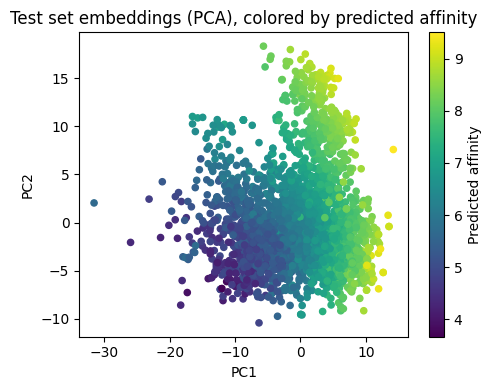

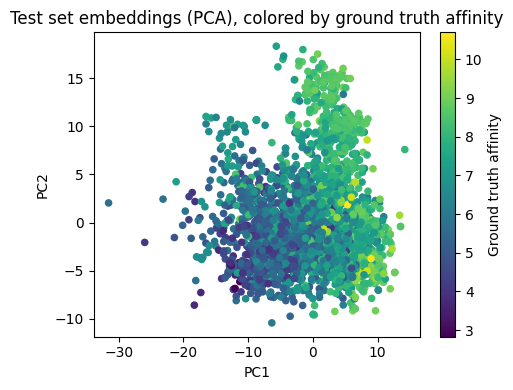

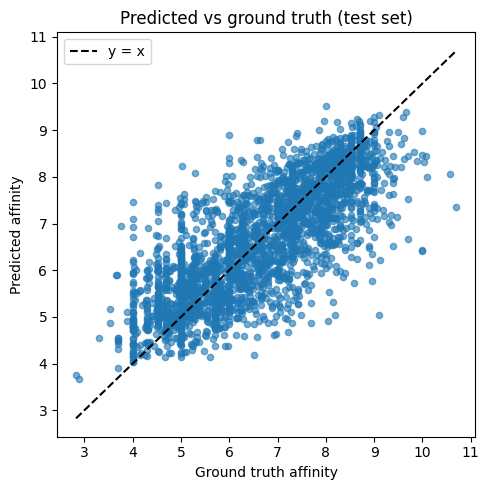

In [ ]:
# Plot 1: PCA scatter colored by predicted affinity
fig, ax = plt.subplots(figsize=(5, 4))
sc = ax.scatter(xy[:, 0], xy[:, 1], c=y_pred, cmap="viridis", s=20)
plt.colorbar(sc, ax=ax, label="Predicted affinity")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Test set embeddings (PCA), colored by predicted affinity")
plt.tight_layout()
plt.savefig(RUN_DIR_SCAFFOLD / "embeddings_pca_predicted.png", dpi=120)
plt.savefig(PAPER_ARTIFACTS / "fig_embeddings_pca_predicted.pdf", bbox_inches="tight")
plt.show()

# Plot 2: PCA scatter colored by ground truth affinity
fig, ax = plt.subplots(figsize=(5, 4))
sc = ax.scatter(xy[:, 0], xy[:, 1], c=y_true, cmap="viridis", s=20)
plt.colorbar(sc, ax=ax, label="Ground truth affinity")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Test set embeddings (PCA), colored by ground truth affinity")
plt.tight_layout()
plt.savefig(RUN_DIR_SCAFFOLD / "embeddings_pca_ground_truth.png", dpi=120)
plt.savefig(PAPER_ARTIFACTS / "fig_embeddings_pca_ground_truth.pdf", bbox_inches="tight")
plt.show()

# Plot 3: Predicted vs ground truth with diagonal
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(y_true, y_pred, alpha=0.6, s=20)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
ax.plot(lims, lims, "k--", label="y = x")
ax.set_xlabel("Ground truth affinity")
ax.set_ylabel("Predicted affinity")
ax.set_title("Predicted vs ground truth (test set)")
ax.legend()
plt.tight_layout()
plt.savefig(RUN_DIR_SCAFFOLD / "predicted_vs_true.png", dpi=120)
plt.savefig(PAPER_ARTIFACTS / "fig_predicted_vs_true.pdf", bbox_inches="tight")
plt.show()

### Paper artifacts (LaTeX-ready)

All tables, best hyperparameters, and figures are saved under `paper_artifacts/` for direct use in a LaTeX paper: CSV + `.tex` for tables, JSON + `.tex` for best hyperparameters, PDF for figures.

In [ ]:
# Write a manifest with LaTeX usage examples
manifest = f"""# Paper artifacts for LaTeX (P00533 illustrative example)
# Generated by Illustrative_Example_DTA_GNN_P00533.ipynb

## Tables (use \\input{{path/to/file.tex}} or paste content)
- table_leakage_ratio.csv / .tex   -- Leakage ratio: Random vs Scaffold
- table_hpo_trials.csv / .tex     -- HPO trials (lr, num_layers, val_rmse)
- table_performance.csv / .tex    -- Val/Test RMSE, MAE, Pearson
- table_top5_molecules.csv / .tex -- Top 5 test molecules by predicted affinity
- table_inference.csv / .tex      -- Inference on 3 SMILES

## Best hyperparameters
- best_hyperparameters.json       -- lr, num_layers, val_rmse
- best_hyperparameters.tex        -- LaTeX tabular (ready to \\input)

## Figures (use \\includegraphics[width=...]{{path/to/file.pdf}})
- fig_leakage_ratio.pdf
- fig_embeddings_pca_predicted.pdf
- fig_embeddings_pca_ground_truth.pdf
- fig_predicted_vs_true.pdf

## Example LaTeX
% Tables:
% \\input{{paper_artifacts/table_performance.tex}}
% \\input{{paper_artifacts/best_hyperparameters.tex}}

% Figures:
% \\includegraphics[width=0.45\\textwidth]{{paper_artifacts/fig_leakage_ratio.pdf}}
% \\includegraphics[width=0.45\\textwidth]{{paper_artifacts/fig_predicted_vs_true.pdf}}
"""
(PAPER_ARTIFACTS / "LATEX_MANIFEST.txt").write_text(manifest)
print("Paper artifacts saved to:", PAPER_ARTIFACTS)
for f in sorted(PAPER_ARTIFACTS.iterdir()):
    print(f"  {f.name}")

Paper artifacts saved to: runs/p00533_scaffold/paper_artifacts
  LATEX_MANIFEST.txt
  best_hyperparameters.json
  best_hyperparameters.tex
  fig_embeddings_pca_ground_truth.pdf
  fig_embeddings_pca_predicted.pdf
  fig_leakage_ratio.pdf
  fig_predicted_vs_true.pdf
  table_hpo_best.csv
  table_hpo_best.tex
  table_inference.csv
  table_inference.tex
  table_leakage_ratio.csv
  table_leakage_ratio.tex
  table_performance.csv
  table_performance.tex
  table_top5_molecules.csv
  table_top5_molecules.tex


## Summary

- **Leakage**: Scaffold split typically has lower leakage ratio than random split (fewer test scaffolds seen in train), which is desirable for generalization.
- **Best hyperparameters**: From HPO, best lr and num_layers (GraphSAGE) were selected by lowest validation RMSE.
- **Final test performance**: RMSE, MAE, and Pearson on the test set are reported in the performance table above.
- **What this notebook demonstrated**: End-to-end DTA-GNN workflow for target P00533: dataset construction with random and scaffold splits, leakage visualization, manual HPO for GraphSAGE (lr, num_layers), training with best hyperparameters, evaluation and top 5 molecules, inference on 3 SMILES, and embedding extraction with PCA scatter plots and predicted vs ground truth.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

def copy_run_to_drive(run_dir: Path, drive_path: str) -> int:
    """Copy all files from run_dir to drive_path, preserving structure. Returns number of files copied."""
    dst = Path(drive_path)
    dst.mkdir(parents=True, exist_ok=True)
    n = 0
    for f in run_dir.rglob("*"):
        if f.is_file():
            rel = f.relative_to(run_dir)
            (dst / rel).parent.mkdir(parents=True, exist_ok=True)
            shutil.copy2(f, dst / rel)
            n += 1
    return n

n_scaffold = copy_run_to_drive(RUN_DIR_SCAFFOLD, DRIVE_PATH_SCAFFOLD)
n_random = copy_run_to_drive(RUN_DIR_RANDOM, DRIVE_PATH_RANDOM)
print(f"Copied {n_scaffold} files to {DRIVE_PATH_SCAFFOLD}")
print(f"Copied {n_random} files to {DRIVE_PATH_RANDOM}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copied 432 files to /content/drive/MyDrive/runs/P00533_scaffold
Copied 3 files to /content/drive/MyDrive/runs/P00533_random
